# Building a stock database using Polygon
The goal is to create a financial database of 1-minute OHLCV data from 2005 and beyond, delisted or listed, for common stocks and ADR common stocks. Including fundamental and adjustment data. I use Polygon for price data. It is actually very annoying to get a survivorship-bias free database. Some vendors do not have delisted stocks at all, while some only have them when the ticker is not re-used. But Polygon does not have all I want, their fundamental data is lacking. While you can get earnings data you cannot query cash (for dilution prediction) and (short) float. I am still searching for a solution.

With the Alpaca notebooks (which are now in the archive) I tried to convert tick quote data to quotes and then merge them with bars to get a realistic bid-ask spread. I have decided to not use quote data anymore. It is simply too expensive, cumbersome or simply impossible. I would have to download ALL tick data in order to get quotebars. Instead, I will just trade using 1-minute OHLC. When backtesting, I will assume a spread of 1 tick or a few cents. This is okay, because I simply will not trade HFT or systems with an average profit less than 0.3% for liquid stocks or less than 0.1% for liquid futures/CFDs. I also will avoid illiquid stocks. If I want a more realistic estimate, I will sample the bid-ask spread throughout the day. 

All Polygon data will be stored in <code>../../../data/polygon/</code>. This map contains a <code>raw</code> and <code>processed</code> folder. The <code>raw</code> folder will contain the folders <code>m1</code>, <code>adjustments</code>, <code>fundamentals</code> and <code>tickers</code>. And a file called <code>tickers_v{version}.csv</code>, which are the list of tickers. The second version is 'cleaned', the third version includes ETFs and the fourth version includes the start/end dates of the price data available in *our* database. The <code>processed</code> folder will contain the folders <code>m1</code>, <code>m5</code>, <code>h1</code>, <code>d1</code>, <code>w1</code>, <code>m1</code>, <code>fundamentals</code> and <code>tickers.csv</code>. Processed data is always adjusted. Raw data is never. Some other data, such as market hours that are not specific to a data vendor, are stored in <code>../../../data/other/</code>. The folders have to be created manually.

(For live trading I will not pay $200/month to Polygon just for real-time data. I will use IBKR for real-time, Polygon for historic, another source for fundamentals historic and another source for realtime fundamentals.)

The series of notebooks:
1. **[done]** Get a list of tickers and market hours. This is way much more difficult than expected. 
2. Get fundamentals (limited).
3. **[done]** Get adjustment factors.
4. Download raw 1-minute OHLC data. Raw price data contains <code>["datetime", "open", "high", "low", "close", "vwap", "trades", "volume", "otc"]</code>. The <code>datetime</code> column is the converted Unix timestamp from the original raw data. The <code>trades</code> column is the amount of trades in the minute and <code>otc</code> is a flag whether the asset is traded OTC. I will not trade OTCs yet. Higher resolutions are not downloaded, but aggregated later. Raw data is never deleted or modified.
5. Clean suspicious bars with quote/tick data.
6. Process data. When data is downloaded for the first time or updated, the *entire* data set needs be processed (for the updated tickers). This is because if new adjustments come in due to dividend or split data, the entire history needs to be readjusted. Processed data will contain the columns <code>["open", "high", "low", "close", "close_original", "volume", "tradeable", "cleaned", "halted"]</code>. All prices are adjusted, except <code>close_original</code>. The reason we need the original close price is for price filters. Processed data should have no gaps. If data is forward filled, the backtester should not trade these 'stale' prices. Either there have been no trades in the minute or the stock is halted. That is what the <code>tradeable</code> flag is for. The <code>cleaned</code> flag is for if the bar has been cleaned. 
7. Aggregate processed minute bars to higher timeframes. The daily timeframes and higher do not contain extended hours.
8. Get index constituents. 
9. Scraping data. Some fundamentals (like short interest) are very hard to get. But the live value is very easy. So I want to look into scraping this info from free websites.

*Note: a data point at 15:59 with OHLC means that the open was at 15:59:00 and close at 16:00:00. So daily data does not contain the 16:00:00 minute bar. My polygon key is in <code>../../../data/polygon/secret.txt</code>, this file has to be created manually, just like the folders.*

*Warning: This is much more work than you think it is. Even though we use easy APIs for both price and fundamental data.*

In [1]:
from polygon.rest import RESTClient
from datetime import datetime, date, time, timedelta
from pytz import timezone
from utils import first_trading_day_after, last_trading_day_before, get_tickers_v1, get_tickers_v2, get_tickers_v3
import os
import pytz
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import mplfinance as mpf

The free tier has a rate limit of 5/minute. Just listing the tickers already goes above the limit. So I will start with the cheapest (29/month) subscription. When I have everything setup, I will upgrade to the highest tier. Then when I have acquired all data, I will likely downgrade to the cheapest subscription just for updates.

The current goal is to download all stocks from 2021-6-1 to 2023-8-18. If I am succesful with that, I will try to get it from the last 5 years which is the maximum for the "starter" subscription. Then finally I can download it all.

In [2]:
DATA_PATH = "../../../data/polygon/"

START_DATE = first_trading_day_after(datetime(2021, 1, 1).date())
END_DATE = last_trading_day_before(datetime(2023, 8, 18).date())
print(START_DATE)
print(END_DATE)

with open(DATA_PATH + "secret.txt") as f:
    KEY = next(f).strip()

client = RESTClient(api_key=KEY)

2021-01-04
2023-08-18


# 1. Getting all tickers

We are only interested in common stocks (CS) and ADR commons (ADRC) in the US only that are not OTC. It must also include the delisted stocks. So we need to get 4 different set of tickers: CS+active, CS+inactive, ADRC+active, ADRC+inactive. Setting the <code>asset_class</code> to "stocks" only pulls non-OTC tickers. The <code>list_tickers</code> returns an iterator. Every iteration is 1 request with the specified <code>limit</code>.


In [3]:
print(pd.DataFrame(client.get_ticker_types(asset_class="stocks", locale="us")))

   asset_class     code                            description locale
0       stocks       CS                           Common Stock     us
1       stocks      PFD                        Preferred Stock     us
2       stocks  WARRANT                                Warrant     us
3       stocks    RIGHT                                 Rights     us
4       stocks     BOND                         Corporate Bond     us
5       stocks      ETF                   Exchange Traded Fund     us
6       stocks      ETN                   Exchange Traded Note     us
7       stocks      ETV                Exchange Traded Vehicle     us
8       stocks       SP                     Structured Product     us
9       stocks     ADRC     American Depository Receipt Common     us
10      stocks     ADRP  American Depository Receipt Preferred     us
11      stocks     ADRW   American Depository Receipt Warrants     us
12      stocks     ADRR     American Depository Receipt Rights     us
13      stocks     F

In [4]:
ticker_list_iterator_active = client.list_tickers(type="CS", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)
ticker_list_iterator_delisted = client.list_tickers(type="CS", date=END_DATE.isoformat(), active=False, market='stocks', limit=1000)
ticker_list_iterator_active_adr = client.list_tickers(type="ADRC", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)
ticker_list_iterator_delisted_adr = client.list_tickers(type="ADRC", date=END_DATE.isoformat(), active=False, market='stocks', limit=1000)
tickers_active = pd.DataFrame(ticker_list_iterator_active)
tickers_delisted = pd.DataFrame(ticker_list_iterator_delisted)
tickers_active_adr = pd.DataFrame(ticker_list_iterator_active_adr)
tickers_delisted_adr = pd.DataFrame(ticker_list_iterator_delisted_adr)

In [5]:
tickers_active.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001090872,BBG000C2V3D6,usd,None,None,None,None,2023-08-31T00:00:00Z,us,stocks,Agilent Technologies Inc.,XNYS,BBG001SCTQY4,A,CS,None
1,True,0001675149,BBG00B3T3HD3,usd,None,None,None,None,2023-09-01T00:00:00Z,us,stocks,Alcoa Corporation,XNYS,BBG00B3T3HF1,AA,CS,None
2,True,0001829432,None,usd,None,None,None,None,2023-09-01T00:00:00Z,us,stocks,Ares Acquisition Corporation,XNYS,None,AAC,CS,None


In [6]:
tickers_delisted.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,False,0000004281,None,usd,None,None,None,2016-10-07T00:00:00Z,2016-10-07T00:00:00Z,us,stocks,ALCOA INC,XNYS,None,AA,CS,None
1,False,0000004281,None,usd,None,None,None,2016-11-01T00:00:00Z,2016-11-01T00:00:00Z,us,stocks,"Alcoa, Inc.",XNYS,None,AA,CS,None
2,False,0001011006,BBG000KB2D74,usd,None,None,None,2019-10-07T00:00:00Z,2019-10-07T00:00:00Z,us,stocks,Altaba Inc. Common Stock,XNAS,BBG001S8V781,AABA,CS,None


In [7]:
tickers_active_adr.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001420529,BBG000V2S3P6,usd,None,None,None,None,2023-08-28T00:00:00Z,us,stocks,ATA Creativity Global American Depositary Shares,XNAS,BBG001T125S9,AACG,ADRC,None
1,True,0001492074,BBG00XRJJLG2,usd,None,None,None,None,2023-08-28T00:00:00Z,us,stocks,Abcam plc American Depositary Shares,XNAS,BBG00XRJJM98,ABCM,ADRC,None
2,True,0001565025,BBG000BN5VZ4,usd,None,None,None,None,2023-08-28T00:00:00Z,us,stocks,AMBEV S.A.,XNYS,BBG005KLVT74,ABEV,ADRC,None


In [8]:
tickers_delisted_adr.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,False,0001611787,BBG00K6FMBQ8,usd,None,None,None,2018-02-12T00:00:00Z,2018-02-12T00:00:00Z,us,stocks,Advanced Accelerator Applications S.A. America...,XNAS,BBG007K5CVB6,AAAP,ADRC,None
1,False,0001091587,BBG000DK5Q25,usd,None,None,None,2023-05-23T00:00:00Z,2023-05-23T00:00:00Z,us,stocks,ABB Ltd.,XNYS,BBG001SDDMX9,ABB,ADRC,None
2,False,0001617582,None,usd,None,None,None,2018-06-13T00:00:00Z,2018-06-13T00:00:00Z,us,stocks,Ablynx NV American Depositary Shares,XNAS,None,ABLX,ADRC,None


In [7]:
tickers = pd.concat([tickers_active, tickers_delisted, tickers_active_adr, tickers_delisted_adr]).reset_index()

Some basic checks to check for weird things:

In [8]:
# Check na values
tickers.isna().sum()

index                       0
active                      0
cik                       649
composite_figi           6175
currency_name               0
currency_symbol         13871
base_currency_symbol    13871
base_currency_name      13871
delisted_utc             5905
last_updated_utc            0
locale                      0
market                      0
name                        0
primary_exchange            0
share_class_figi         6175
ticker                      0
type                        0
source_feed             13871
dtype: int64

In [9]:
# Check unique values 
print(tickers['currency_name'].unique()) # Should be USD only
print(tickers['locale'].unique()) # Should be US only

['usd']
['us']


In [12]:
# Clean up and rearrange columns
tickers_active = tickers_active[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers_delisted = tickers_delisted[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers_active_adr = tickers_active_adr[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers_delisted_adr = tickers_delisted_adr[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers = tickers[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]

## 1.1 Ticker issues

In [13]:
# Check if all tickers are unique
ticker_frequency = tickers.pivot_table(columns=['ticker'], aggfunc='size')
ticker_frequency[ticker_frequency > 1]

ticker
AA      3
AAC     4
AAN     4
AAU     2
AAV     2
       ..
ZME     2
ZOM     2
ZSAN    3
ZTR     2
ZYME    2
Length: 1978, dtype: int64

In [14]:
# Apparently they are not unique. There are more than 1800 duplications. Maybe it is because tickers get recycled after delisting?
ticker_frequency_active = tickers_active.pivot_table(columns=['ticker'], aggfunc='size')
ticker_frequency_active[ticker_frequency_active > 1]

Series([], dtype: int64)

In [15]:
# There are indeed no duplicates in the active stocks. The tickers are recycled:
tickers[tickers['ticker'] == "AAN"]


,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
10,AAN,"The Aaron's Company, Inc.",True,None,2023-08-28T00:00:00Z,0001821393,BBG00WCNDCZ6,CS
5492,AAN,AARON'S INC CL B,False,2010-12-14T00:00:00Z,2010-12-14T00:00:00Z,0000706688,None,CS
5493,AAN,"Aaron's, Inc.",False,2020-10-19T00:00:00Z,2020-10-19T00:00:00Z,0000706688,BBG00JZD1964,CS
5494,AAN,"Aaron''s Holdings Company, Inc.",False,2020-12-01T00:00:00Z,2020-12-01T00:00:00Z,0001821393,BBG00XYJSN34,CS


In [16]:
# We need to keep this in mind if we download historical data. Because we cannot just loop through all tickers and then store them in a csv. Because then the first ones will be overwritten.

# Maybe the cik is unique?
ticker_frequency = tickers.pivot_table(columns=['cik'], aggfunc='size')
ticker_frequency[ticker_frequency > 1]

cik
0000002186    3
0000002491    2
0000003197    2
0000003327    3
0000003453    2
             ..
0001951067    2
0001951222    2
0001955520    2
0001965040    2
0001968915    2
Length: 2416, dtype: int64

In [17]:
# There are also cik duplicates.
tickers[tickers['cik'] == "0000002186"]


,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
707,BKTI,BK Technologies Corporation,True,None,2023-08-28T00:00:00Z,0000002186,BBG00NKSM4N7,CS
6363,BKTI,BK Technologies Corporation,False,2023-04-24T00:00:00Z,2023-04-24T00:00:00Z,0000002186,BBG00NKSM4N7,CS
11432,RWC,RELM Wireless Corporation,False,2018-06-05T00:00:00Z,2018-06-05T00:00:00Z,0000002186,None,CS


What we can do to handle delisted tickers (e.g. multiple AAC) when downloading is:
- For the active tickers, just save the data in AAC.csv, as there are no duplicate tickers.
- For the inactive tickers, we will add the delisted year and month to the end of the ticker: AAC-2009-01.csv. This is also what Norgate Data does. If there are 2 delistings from the same ticker in the same month, also the day will be added: AAC-2009-01-01
- We need to keep in mind that it is possible for a ticker to go to OTC and then back (see HTZ on TradingView). We will treat these cases as two different stocks, such that we do not trade OTC. We won't even use the OTC data.

*Note: I decided to name delisted and listed tickers with the ticker + start date. Because the start date never changes, while the end date does. This makes things easier, although not as elegant.*

In [18]:
tickers.sort_values(by=['ticker'], inplace=True)
# We are not interested in stocks that were delisted before the start date
tickers['delisted_utc'] = pd.to_datetime(tickers['delisted_utc'])
tickers['last_updated_utc'] = pd.to_datetime(tickers['last_updated_utc'])
tickers = tickers[(tickers['delisted_utc'].dt.date > START_DATE) | tickers['delisted_utc'].isnull()]
tickers.reset_index(inplace=True, drop=True)
tickers

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
0,A,Agilent Technologies Inc.,True,NaT,2023-08-28 00:00:00+00:00,0001090872,BBG000C2V3D6,CS
1,AA,Alcoa Corporation,True,NaT,2023-08-28 00:00:00+00:00,0001675149,BBG00B3T3HD3,CS
2,AAC,Ares Acquisition Corporation,True,NaT,2023-08-28 00:00:00+00:00,0001829432,None,CS
3,AACG,ATA Creativity Global American Depositary Shares,True,NaT,2023-08-28 00:00:00+00:00,0001420529,BBG000V2S3P6,ADRC
4,AACI,Armada Acquisition Corp. I Common Stock,True,NaT,2023-08-28 00:00:00+00:00,0001844817,BBG011XR7306,CS
...,...,...,...,...,...,...,...,...
8178,ZY,Zymergen Inc. Common Stock,False,2022-10-20 00:00:00+00:00,2022-10-20 00:00:00+00:00,0001645842,BBG0077HPN74,CS
8179,ZYME,Zymeworks Inc.,False,2022-10-13 00:00:00+00:00,2022-10-13 00:00:00+00:00,0001403752,BBG00GD15LJ5,CS
8180,ZYME,Zymeworks Inc.,True,NaT,2023-08-28 00:00:00+00:00,0001937653,BBG019XSYC89,CS
8181,ZYNE,"Zynerba Pharmaceuticals, Inc",True,NaT,2023-08-28 00:00:00+00:00,0001621443,BBG007BBS8B7,CS


We now have the end dates. But to download the data we also need the start date. Let's try to get the start date of META. To get them we could use the <code>Ticker Details</code> endpoint. But this gets the *list date*. This is not necessarily the same as the start date of a ticker. E.g. FB changed their ticker to META, but what does ticker details give? We want 2022.

(If a ticker changes, just like normal, we treat them as 2 different stocks. In the end, we should thus get a META.csv and a FB.csv. We can merge them later *after* downloading all data. The purpose of the ticker list is to know what data to download.)

In [19]:
meta_details = client.get_ticker_details(ticker = "META")
meta_details.list_date

'2012-05-18'

In [20]:
result = client.get_ticker_events(ticker="META")
result

TickerChangeResults(name='Meta Platforms, Inc. Class A Common Stock', composite_figi='BBG000MM2P62', cik='0001326801', events=[{'ticker_change': {'ticker': 'META'}, 'type': 'ticker_change', 'date': '2022-06-09'}, {'ticker_change': {'ticker': 'FB'}, 'type': 'ticker_change', 'date': '2012-05-18'}])

The start date of META is 2022-06-09. But the list date is the one from FB from 2012. We cannot use <code>get_ticker_events</code> because it does not include delisted companies. So to reiterate, our current goal is to get the 2022-06-09 *without* <code>get_ticker_events</code> in order to download the correct data for META.

What happens if we download data from a ticker that has multiple changes? If we use META we expect only data from 2022-06-09 to now. If we use FB we expect data from 2012 to 2022-06-08.

In [21]:
meta_iterator = client.get_aggs(ticker = "META", multiplier = 1, timespan = "day", from_ = "2010-01-01", to = "2023-08-18", limit=50000)
meta_d1 = pd.DataFrame(meta_iterator)
meta_d1["timestamp"] = pd.to_datetime(meta_d1["timestamp"], unit="ms").dt.date
meta_d1.rename(columns={"timestamp": "date"}, inplace=True)
meta_d1


,open,high,low,close,volume,vwap,date,transactions,otc
0,15.0800,15.19,15.042,15.12,334935.0,15.1107,2021-06-30,2101,None
1,15.1300,15.13,14.840,14.89,241629.0,15.0126,2021-07-01,2092,None
2,15.0200,15.10,14.930,15.00,388152.0,15.0224,2021-07-02,4733,None
3,15.0800,15.09,14.870,15.01,685094.0,15.1119,2021-07-06,11269,None
4,15.0601,15.15,14.840,14.89,362538.0,14.9830,2021-07-07,5538,None
...,...,...,...,...,...,...,...,...,...
443,300.9800,306.21,298.250,306.19,15641921.0,303.0529,2023-08-14,206053,None
444,306.1400,307.23,300.030,301.95,11623613.0,302.9223,2023-08-15,171652,None
445,300.1950,301.08,294.280,294.29,18547741.0,297.3013,2023-08-16,261408,None
446,293.0500,296.05,284.950,285.09,23950089.0,289.9367,2023-08-17,311835,None


This is absolutely not what we expected. We expected data from either 2022-06-09 (from when the ticker was renamed) or the start of FB (in 2012). This means that there was a ticker named META before FB renamed.

In [22]:
tickers[tickers['ticker'] == "META"]

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
4678,META,"Meta Platforms, Inc. Class A Common Stock",True,NaT,2023-08-28 00:00:00+00:00,0001326801,BBG000MM2P62,CS


In [23]:
tickers[tickers['ticker'] == "FB"]

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type


What? Why is there no META ticker before 2022-06-09? Why is there no FB ticker?

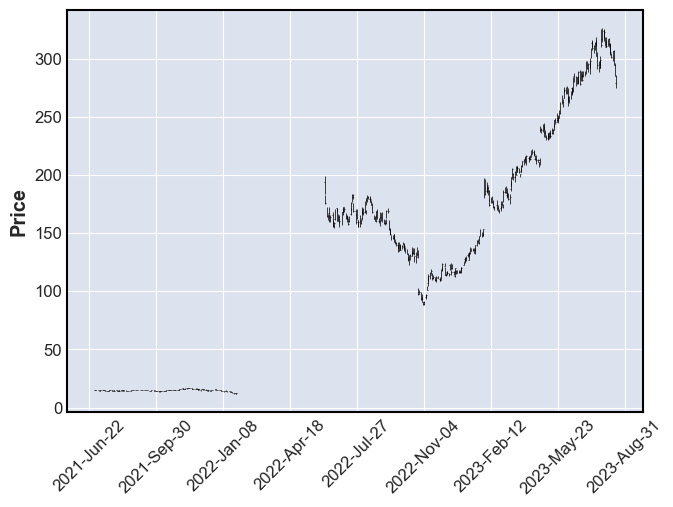

In [24]:
# fig = go.Figure(data=go.Ohlc(x=meta_d1['date'],
#                     open=meta_d1['open'],
#                     high=meta_d1['high'],
#                     low=meta_d1['low'],
#                     close=meta_d1['close']))
# fig.show()

meta_d1.set_index("date", inplace=True)
meta_d1.index = pd.to_datetime(meta_d1.index)
mpf.plot(meta_d1, type='ohlc', show_nontrading=True)

Why?

In [25]:
fb_iterator = client.get_aggs(ticker = "FB", multiplier = 1, timespan = "day", from_ = "2010-01-01", to = "2023-08-18", limit=50000)
fb_d1 = pd.DataFrame(fb_iterator)
fb_d1["timestamp"] = pd.to_datetime(fb_d1["timestamp"], unit="ms").dt.date
fb_d1.rename(columns={"timestamp": "date"}, inplace=True)
fb_d1

,open,high,low,close,volume,vwap,date,transactions,otc
0,175.90,179.7901,175.7000,177.64,24216532.0,178.2862,2018-08-30,172773,None
1,177.15,177.6200,174.9815,175.73,18065159.0,175.7343,2018-08-31,135914,None
2,173.50,173.8900,168.8000,171.16,29808971.0,171.1312,2018-09-04,234508,None
3,169.49,171.1250,166.6700,167.18,31203944.0,168.3393,2018-09-05,237150,None
4,166.98,166.9800,160.0000,162.53,41509084.0,163.0707,2018-09-06,322847,None
...,...,...,...,...,...,...,...,...,...
945,188.45,200.9350,187.7300,198.86,31951582.0,195.8094,2022-06-02,336899,None
946,195.98,196.6100,189.7800,190.78,19464993.0,192.0885,2022-06-03,239486,None
947,193.99,196.9200,188.4000,194.25,30574242.0,193.2857,2022-06-06,307707,None
948,191.93,196.5300,191.4900,195.65,18628687.0,194.4583,2022-06-07,204288,None


Why does there exist data for FB if the ticker list does not include it? I thought the <code>Tickers</code> endpoint did not rename but only added new tickers. Apparently that is not the case:

In [26]:
# Before the renaming on 6-9
ticker_list_iterator_fb = client.list_tickers(ticker="FB", type="CS", date="2022-06-08", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001326801,BBG000MM2P62,usd,None,None,None,None,2022-06-08T00:00:00Z,us,stocks,"Meta Platforms, Inc. Class A Common Stock",XNAS,BBG001SQCQC5,FB,CS,None


In [27]:
ticker_list_iterator_fb = client.list_tickers(ticker="FB", type="CS", date="2022-06-08", active=False, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

""


In [28]:
# After the renaming on 6-9: No FB but we do have META
ticker_list_iterator_fb = client.list_tickers(ticker="FB", type="CS", date="2022-06-09", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

""


In [29]:
ticker_list_iterator_fb = client.list_tickers(ticker="FB", type="CS", date="2022-06-09", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

""


In [30]:
ticker_list_iterator_fb = client.list_tickers(ticker="META", type="CS", date="2022-06-09", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001326801,BBG000MM2P62,usd,None,None,None,None,2022-06-09T00:00:00Z,us,stocks,"Meta Platforms, Inc. Class A Common Stock",XNAS,BBG001SQCQC5,META,CS,None


Apparently when a stock renames, the <code>Tickers</code> gets updated by removing the old ticker and adding the new one. It also does not treat it as a delisting (there is no <code>delisted_utc</code>).

The old META is actually an ETF and renamed to METV.

In [33]:
client.get_ticker_details(ticker="META", date="2022-01-01")

TickerDetails(active=True, address=None, branding=None, cik=None, composite_figi='BBG011J1MN62', currency_name='usd', currency_symbol=None, base_currency_name=None, base_currency_symbol=None, delisted_utc=None, description=None, ticker_root='META', ticker_suffix=None, homepage_url=None, list_date='2021-06-30', locale='us', market='stocks', market_cap=None, name='Roundhill Ball Metaverse ETF', phone_number=None, primary_exchange='ARCX', share_class_figi='BBG011J1MP12', share_class_shares_outstanding=60080000, sic_code=None, sic_description=None, ticker='META', total_employees=None, type='ETF', weighted_shares_outstanding=None)

In [34]:
ticker_list_iterator_meta = client.list_tickers(ticker="META", date="2022-01-01", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_meta)
df

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,None,BBG011J1MN62,usd,None,None,None,None,2022-01-02T00:00:00Z,us,stocks,Roundhill Ball Metaverse ETF,ARCX,BBG011J1MP12,META,ETF,None


This is quite problematic. The only way to get the end date of FB is to loop through all trading days in <code>Tickers</code> and see when the ticker dissappears. The only way to get the start date of the META or FB is also to loop, but then to track when the ticker appears. Or use the <code>Ticker Events</code> however this only works for current tickers and not delisted ones. So information actually gets lost in the <code>Tickers</code> endpoint.

Who thought that just getting all available tickers would be such a headache? We haven't even begun downloading data.

To summarize:
- Getting data is truly point-in-time, there is no META data for 2022-04-01 (after META ETF, before FB rename), but there is FB data before the META renaming. If the same ticker had different stocks, they are merged when downloading data which we do not want. So we **must** specify a precise start and end date for each stock, else we might get merging from different stocks. And it is not possible to get the start and end dates from <code>list_tickers</code>. Because it simply does not contain the start date. And also not the renamed tickers.
- The <code>Tickers</code> endpoint does **not** include FB in the 'inactive' tickers if we use the current date. So the <code>Tickers</code> is also 'point in time' and **deletes** some data, such as FB.

So we will loop and create an own version of a list of all tickers with start and end dates. This will include FB, which would not be the case if we only used the current date in <code>Tickers</code>. It would also include the old META ETF if it was a stock. This would be impossible to get without looping.

## 1.2 Trading dates and hours
First a small experiment: What is the earliest data that Polygon has? I simply used trial-and-error. The earliest date is 2003-09-10. That is quite a lot. 

In [10]:
ticker_list_iterator = client.list_tickers(date="2003-09-10", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator)
len(df)

8204

In order to loop through the trading dates, we still need to get the trading dates. Also there are holidays and early closes. We can infer the holidays by just looking at daily SPY data. But this does not include information about early closes. The goal is to create a csv with dates and the start times of pre-market and regular hours and end times of post-market.

The early closes are listed on [QuantConnect](https://www.quantconnect.com/docs/v2/writing-algorithms/securities/asset-classes/us-equity/market-hours).

So we will first get a list of all trading dates using SPY data. The regular hours always start at 9:30 ET. The start of premarket is 4:00 ET. To test if it is always 4:00 ET we will compare it to the 1-minute SPY data. There are no early or late opens. To get the close we will use 16:00 ET or 13:00 ET if it is an early close. The post-market ends 4 hours after close. We will also test this on the SPY minute data.

In [11]:
###
path = DATA_PATH + "../other/market_hours.csv"

# Get list of trading dates
if os.path.isfile(path):
    # If we already have it we just need to update
    old_market_hours = pd.read_csv(
            path,
            parse_dates=True,
        )
    old_market_hours["date"] = pd.to_datetime(old_market_hours["date"]).dt.date
    old_trading_days = old_market_hours[["date"]]
    last_day_old = old_trading_days['date'].values[-1]

    SPY_d1 = pd.DataFrame(client.get_aggs(ticker = "SPY", multiplier = 1, timespan = "day", from_ = (last_day_old + timedelta(days=1)).isoformat(), to = END_DATE, limit=50000))
    SPY_d1["timestamp"] = pd.to_datetime(SPY_d1["timestamp"], unit="ms").dt.date
    SPY_d1.rename(columns = {"timestamp": "date"}, inplace=True)
    new_trading_days = SPY_d1[["date"]]

    trading_days = pd.concat([old_trading_days, new_trading_days])
    trading_days.drop_duplicates(inplace=True)
    trading_days.sort_values(by='date', inplace=True)
else: 
    # If we do not, download everything
    SPY_d1 = pd.DataFrame(client.get_aggs(ticker = "SPY", multiplier = 1, timespan = "day", from_ = START_DATE, to = END_DATE, limit=50000))
    SPY_d1["timestamp"] = pd.to_datetime(SPY_d1["timestamp"], unit="ms").dt.date
    SPY_d1.rename(columns = {"timestamp": "date"}, inplace=True)
    trading_days = SPY_d1[["date"]]

# Fill with pre-market/regular session
trading_hours = trading_days.copy()
trading_hours["premarket_open"] = time(4)
trading_hours["regular_open"] = time(9, 30)

# Fill in early closes/post-market
early_closes = ['1999-11-26','2000-07-03','2000-11-24','2001-07-03','2001-11-23',
'2001-12-24','2002-07-05','2002-11-29','2002-12-24','2003-07-03','2003-11-28',
'2003-12-24','2003-12-26','2004-11-26','2005-11-25','2006-07-03','2006-11-24',
'2007-07-03','2007-11-23','2007-12-24','2008-07-03','2008-11-28','2008-12-24',
'2009-11-27','2009-12-24','2010-11-26','2011-11-25','2012-07-03','2012-11-23',
'2012-12-24','2013-07-03','2013-11-29','2013-12-24','2014-07-03','2014-11-28',
'2014-12-24','2015-11-27','2015-12-24','2016-11-25','2017-07-03','2017-11-24',
'2017-12-24','2018-07-03','2018-11-23','2018-12-24','2019-07-03','2019-11-29',
'2019-12-24','2020-11-27','2020-12-24','2021-11-26','2022-11-25','2023-07-03',
'2023-11-24','2024-07-03',]
early_closes = [datetime.strptime(date, "%Y-%m-%d").date() for date in early_closes]

trading_hours["regular_close"] = trading_hours["date"].isin(early_closes)
trading_hours["regular_close"] = trading_hours["regular_close"].apply(lambda boolean: time(13) if boolean else time(16))

trading_hours["postmarket_close"] = pd.to_datetime(trading_hours['date'].astype(str) + " " + trading_hours["regular_close"].astype(str)) + timedelta(hours=4)
trading_hours["postmarket_close"] = trading_hours["postmarket_close"].dt.time

trading_hours.set_index("date", inplace=True)
trading_hours.to_csv(path)

# 2023-07-03 was an early close day
trading_hours[trading_hours.index == date(2023, 7, 3)]

,premarket_open,regular_open,regular_close,postmarket_close
date,,,,
2023-07-03,04:00:00,09:30:00,13:00:00,17:00:00


According to [Schwab](https://www.schwab.com/public/schwab/nn/qq/about_extended_hours_trading.html) there are no extended hours on trading days with early closes. I could not find confirmation for this so I will test this claim.

(The reason why we need to be precise about this is for the backtester and for aggregating into daily bars.)

In [28]:
# Some handy functions
def datetime_to_unix(year=None, month=None, date=None, hour=0, minute=0, dt=None):
    """
    Converts a ET datetime to the corresponding Unix msec stamp.
    The input can either be year/month/date or a datetime object.
        Input must be either
            year : int
            month : int
            date : int
            hour : int (optional)
            minute : int (optional)
        Or
            dt : datetime (keyword-only)
    """
    if all(isinstance(value, int) for value in (year, month, date, hour, minute)):
        time_ET = timezone("US/Eastern").localize(datetime(year, month, date, hour, minute))
    elif isinstance(dt, datetime):
        time_ET = timezone("US/Eastern").localize(dt)
    else:
        raise Exception("No year/month/date or datetime object specified.")
    
    return int(time_ET.timestamp()*1000)

def download_m1_raw_data(ticker, from_, to, path):
    """
    Downloads 1-minute data from Polygon, converts to ET-naive time and store. Includes extended hours.
        ticker : str
        from_ : tuple(year : int, month : int, date : int) or datetime
        to : tuple(year : int, month : int, date : int) or datetime
        path : str
    """
    # Check if int or datetime given for from_, then get start_unix
    if isinstance(from_, datetime):
        start_unix = datetime_to_unix(dt = from_)
    elif all(isinstance(value, int) for value in from_):
        start_unix = datetime_to_unix(*from_, hour=4) # (* unpacks the tuple)
    else:
        raise Exception("No year/month/date or datetime object specified.")
    
    # Check if int or datetime given for to, then get end_unix
    if isinstance(to, datetime):
        end_unix = datetime_to_unix(dt = to)
    elif all(isinstance(value, int) for value in to):
        # Technically the last minute is 19:59 or earlier on early closes, but if we download 20:00 the last bar (or hours for early closes) will simply not exist. So for simplicity we just use hour = 20.
        end_unix = datetime_to_unix(*to, hour = 20) # (* unpacks the tuple)
    else:
        raise Exception("No year/month/date or datetime object specified.")

    m1 = pd.DataFrame(client.list_aggs(ticker = ticker, multiplier = 1, timespan = "minute", from_ = start_unix, to = end_unix, limit=10000))
    m1["timestamp"] = pd.to_datetime(m1["timestamp"], unit="ms") # Convert timestamp to UTC
    m1.rename(columns = {"timestamp": "datetime"}, inplace=True)
    m1["datetime"] = m1["datetime"].dt.tz_localize(pytz.UTC) # Make UTC aware (in order to convert)
    m1["datetime"] = m1["datetime"].dt.tz_convert("US/Eastern") # Convert UTC to ET
    m1["datetime"] = m1["datetime"].dt.tz_localize(None) # Make timezone naive 
    m1.set_index("datetime", inplace=True)
    m1.to_csv(path)

def get_trading_days():
    """
    Get a list of trading dates.
    """
    if os.path.isfile(DATA_PATH + "../other/market_hours.csv"):
        trading_hours = pd.read_csv(
            DATA_PATH + "../other/market_hours.csv",
            usecols=["date"],
            index_col="date",
            parse_dates=True,
        )
        return list(trading_hours.index.date)
    else:
        raise Exception("There is no file for market hours.")

def first_trading_day_after(dt):
    """
    Gets first trading day after input date. If there is no file, return the input.
    """
    trading_days = get_trading_days()
    while dt not in trading_days:
        dt = dt + timedelta(days=1)
    return dt

def last_trading_day_before(dt):
    """
    Gets last trading day before input date. If there is no file, return the input.
    """
    trading_days = get_trading_days()
    while dt not in trading_days:
        dt = dt - timedelta(days=1)
    return dt

In [ ]:
download_m1_raw_data("SPY", from_ = (2019, 1, 2), to = (2023, 8, 18), 
path = DATA_PATH + "/raw/m1/SPY.csv")

Let's first test if the trading days match between daily and minute bars.

In [44]:
SPY_m1 = pd.read_csv(
        DATA_PATH + "/raw/m1/SPY.csv",
        parse_dates=True,
        index_col="datetime",
        usecols=["datetime"]
    )
market_hours = pd.read_csv(
        DATA_PATH + "../other/market_hours.csv",
        index_col="date",
        parse_dates=True,
    )

market_open_days = set(market_hours.index.date)
# Test for duplicated days in daily data, should be False
print(all(market_hours.duplicated()))

market_open_days_m1 = set(SPY_m1.index.date)

# We might have that there are more data in the market_hours than a specific stock. So we only have to test for containment.
print(market_open_days_m1.issubset(market_open_days))

# In this case however, the daily and minute match exactly:
print(market_open_days.issubset(market_open_days_m1))

False
True
True


Now we will test if the first minute of trading always matches 4:00 ET. As there are not always trades in the first exact minute, we will only look at the hour.

In [42]:
SPY_m1["date"] = SPY_m1.index.date
SPY_m1["hour"] = SPY_m1.index.hour
SPY_m1

,date,hour
datetime,,
2019-01-02 04:00:00,2019-01-02,4
2019-01-02 04:01:00,2019-01-02,4
2019-01-02 04:02:00,2019-01-02,4
2019-01-02 04:03:00,2019-01-02,4
2019-01-02 04:04:00,2019-01-02,4
...,...,...
2023-08-18 19:53:00,2023-08-18,19
2023-08-18 19:56:00,2023-08-18,19
2023-08-18 19:57:00,2023-08-18,19


In [43]:
SPY_open = SPY_m1[~SPY_m1["date"].duplicated()] # By removing duplicates we get the first 1-minute bar of each day.
SPY_open[SPY_open["hour"] != 4]

,date,hour
datetime,,


Hence the pre-market always starts at 4:00 ET. Even for early closes. Now let's check post-market hours for early closes. On 2023-7-3 the market closed at 13:00 ET. We would then expect the post-market to continue for 4 hours until 17:00 ET instead ot 20:00 ET.

In [44]:
SPY_m1[SPY_m1['date'] == date(2023, 7, 3)]

,date,hour
datetime,,
2023-07-03 04:00:00,2023-07-03,4
2023-07-03 04:01:00,2023-07-03,4
2023-07-03 04:02:00,2023-07-03,4
2023-07-03 04:03:00,2023-07-03,4
2023-07-03 04:04:00,2023-07-03,4
...,...,...
2023-07-03 16:43:00,2023-07-03,16
2023-07-03 16:45:00,2023-07-03,16
2023-07-03 16:52:00,2023-07-03,16


Indeed this is the case. The 16:59 minute means that the market closes at 17:00. Let's see if this is the case for all early closes.

In [45]:
SPY_close = SPY_m1[~SPY_m1["date"].duplicated(keep="last")] # By removing duplicates except the last we get the last 1-minute bar of a day.
SPY_close

,date,hour
datetime,,
2019-01-02 19:59:00,2019-01-02,19
2019-01-03 19:59:00,2019-01-03,19
2019-01-04 19:59:00,2019-01-04,19
2019-01-07 19:59:00,2019-01-07,19
2019-01-08 19:59:00,2019-01-08,19
...,...,...
2023-08-14 19:59:00,2023-08-14,19
2023-08-15 19:59:00,2023-08-15,19
2023-08-16 19:59:00,2023-08-16,19


In [46]:
SPY_close[SPY_close["hour"] != 19]

,date,hour
datetime,,
2019-07-03 16:59:00,2019-07-03,16
2019-08-12 20:12:00,2019-08-12,20
2019-11-29 16:59:00,2019-11-29,16
2019-12-24 16:59:00,2019-12-24,16
2020-01-08 20:00:00,2020-01-08,20
2020-04-07 20:00:00,2020-04-07,20
2020-07-01 20:00:00,2020-07-01,20
2020-08-10 20:00:00,2020-08-10,20
2020-08-20 20:00:00,2020-08-20,20


We expected to see only 16:59 (or earlier if no trades happened. But we always expect 16:xx). I will just assume the 20:00:00 is a rounding error that sometimes occurs. If we ignore the 20:00, do the early closes match the list from QuantConnect?

In [47]:
SPY_early_closes = SPY_close[SPY_close["hour"] == 16]
list(SPY_early_closes["date"].values)

[datetime.date(2019, 7, 3),
 datetime.date(2019, 11, 29),
 datetime.date(2019, 12, 24),
 datetime.date(2020, 11, 27),
 datetime.date(2020, 12, 24),
 datetime.date(2021, 11, 26),
 datetime.date(2022, 11, 25),
 datetime.date(2023, 7, 3)]

In [48]:
early_closes[-10:-2]

[datetime.date(2019, 7, 3),
 datetime.date(2019, 11, 29),
 datetime.date(2019, 12, 24),
 datetime.date(2020, 11, 27),
 datetime.date(2020, 12, 24),
 datetime.date(2021, 11, 26),
 datetime.date(2022, 11, 25),
 datetime.date(2023, 7, 3)]

They match. So to summarize: pre-market always starts at 4:00. The market always opens at 9:30. The market closes at 16:00, except on early closes where the close is 13:00. The post-market always closes 4 hours after the regular close.

So far, we have learned some quirks of the Polygon API and established the market hours. We now will loop through all trading dates and get a list of all tickers. After that we can finally start downloading our data. We haven't even finished the backtester yet. But with just Pandas you can already do some vectorized backtesting and analysis.

## 1.3 Getting all tickers

Now we can create our ticker list. First we will download all ticker lists from Polygon.

In [24]:
###
def get_tickers(year=None, month=None, date_=None, dt=None):
    """
    Get all CS and ADRC, delisted and listed.
        Input must be either
            year : int
            month : int
            date_ : int
        Or
            dt : datetime or date object (keyword-only)
    """
    if all(isinstance(value, int) for value in (year, month, date_)):
        datetime_date = datetime(year, month, date_).date()
        
    elif isinstance(dt, datetime):
        datetime_date = dt.date()
    elif isinstance(dt, date):
        datetime_date = dt
    else:
        raise Exception("No year/month/date or datetime object specified.")
    
    date_iso = datetime_date.isoformat()

    ticker_list_iterator_active = client.list_tickers(type="CS", date=date_iso, active=True, market='stocks', limit=1000)
    ticker_list_iterator_delisted = client.list_tickers(type="CS", date=date_iso, active=False, market='stocks', limit=1000)
    ticker_list_iterator_active_adr = client.list_tickers(type="ADRC", date=date_iso, active=True, market='stocks', limit=1000)
    ticker_list_iterator_delisted_adr = client.list_tickers(type="ADRC", date=date_iso, active=False, market='stocks', limit=1000)
    tickers_active = pd.DataFrame(ticker_list_iterator_active)
    tickers_delisted = pd.DataFrame(ticker_list_iterator_delisted)
    tickers_active_adr = pd.DataFrame(ticker_list_iterator_active_adr)
    tickers_delisted_adr = pd.DataFrame(ticker_list_iterator_delisted_adr)

    tickers_all = pd.concat([tickers_active, tickers_delisted, tickers_active_adr, tickers_delisted_adr])
    tickers_all.sort_values(by = "ticker", inplace=True)
    tickers_all.reset_index(inplace=True, drop=True)
    return tickers_all[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]

In [ ]:
###
# Get list of dates of ticker lists that we already have
filenames = next(os.walk(DATA_PATH + "raw/tickers"), (None, None, []))[2] #From https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
available_dates = [date.fromisoformat(date_string.replace(".csv", "")) for date_string in filenames]

trading_days = get_trading_days()
for day in trading_days:
    if day >= START_DATE and day <= END_DATE and day not in available_dates:
        isoformat = day.isoformat()
        tickers = get_tickers(dt = day)
        tickers.to_csv(DATA_PATH + f"raw/tickers/{isoformat}.csv")
        print(f"Downloaded tickers for {isoformat}")

Check: random check of the ticker list

In [30]:
tickers_1 = pd.read_csv(
        DATA_PATH + "raw/tickers/2022-06-07.csv",
        index_col=0
    )
tickers_1

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
0,A,Agilent Technologies Inc.,True,NaN,2022-06-14T00:00:00Z,1090872.0,BBG000C2V3D6,CS
1,AA,"Alcoa, Inc.",False,2016-11-01T00:00:00Z,2016-11-01T00:00:00Z,4281.0,NaN,CS
2,AA,ALCOA INC,False,2016-10-07T00:00:00Z,2016-10-07T00:00:00Z,4281.0,NaN,CS
3,AA,Alcoa Corporation,True,NaN,2022-07-20T00:00:00Z,1675149.0,BBG00B3T3HD3,CS
4,AAAP,Advanced Accelerator Applications S.A. America...,False,2018-02-12T00:00:00Z,2018-02-12T00:00:00Z,1611787.0,BBG00K6FMBQ8,ADRC
...,...,...,...,...,...,...,...,...
12880,ZY,Zymergen Inc. Common Stock,True,NaN,2022-07-24T00:00:00Z,1645842.0,BBG0077HPN74,CS
12881,ZYME,Zymeworks Inc.,True,NaN,2022-08-07T00:00:00Z,1403752.0,BBG00GD15LJ5,CS
12882,ZYNE,"Zynerba Pharmaceuticals, Inc",True,NaN,2022-07-25T00:00:00Z,1621443.0,BBG007BBS8B7,CS
12883,ZYXI,ZYNEX INC,True,NaN,2022-06-13T00:00:00Z,846475.0,BBG000BJBXZ2,CS


What we also observe is that the <code>last_updated_utc</code> does not match the date of the ticker list. So this value is not point-in-time. We would expect it all to be 2022-06-09 or earlier, but e.g. for AA this value is 2022-07-20. The <code>delisted_utc</code> is something that only changes once and never updates again.

When we look at the first few rows, we see something weird. There are 3 Alcoa stocks with the same ticker AA. But they are the same company (if you pull up the chart on TradingView you get the entire history including before 2016). If we did nothing extra, we would treat these as 3 different stocks. What we should do is after downloading see if there are stocks that are the same (same name, same ticker, connecting delisting/listing dates). Then merge them. We should also do this for stocks that were renamed.

Check: What happens with multi-day halts? TOP was halted from 13 to 29 May 2023. We would like to see that the stock is active, as it is not delisted but just halted. When processing our data we should just forward fill and set a <code>tradeable</code> to False.

In [7]:
tickers_1 = pd.read_csv(
        DATA_PATH + "raw/tickers/2023-05-22.csv",
        index_col=0
    )
tickers_1[tickers_1["ticker"] == "TOP"]

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
12169,TOP,TOP Financial Group Limited Ordinary Shares,True,NaN,2023-06-29T00:00:00Z,1848275.0,NaN,CS


This is what we wanted to see.

Now we can finally create our ticker list, which includes all tickers. The process involves updating our ticker list every day.
1. Start with the ticker list on day 1. This is the only day where our ticker list is the same as Polygon. Create a column start_date which is day 1 and end_date with is empty. We are only interested in stocks that were active on that day. We will denote our ticker list by T.
2. For all *i = 2 ... n* days (only the active stocks):
    * For the stocks that are in T but not in *i*: These are the stocks that are either delisted (set inactive) or removed by Polygon (e.g. FB). Then for the corresponding ticker we update end_date in T to day *i*. (Two tickers are the 'same' if all fields except <code>last_updated_utc</code> or <code>delisted_utc</code> are the same.)
    * For the stocks that are in *i* but not in T: These are the new stocks that are just listed (or just renamed). We will append the new stock to T, set start_date to *i*.
    * For the stocks that are both in T and *i*: Update <code>last_updated_utc</code> in our ticker list with the updated ticker list. This is what happens for most stocks.

For testing, we will start with 2022-06-08 and update to 2022-06-09. Both FB and META should then be included with the correct start and end dates. The start and end date of FB should be 2022-06-08 and the start date of META should be 2022-06-09. The end date of META should be empty.

In [62]:
start_date = date(2022, 6, 8)
update_date = date(2022, 6, 9)

tickers_all = pd.read_csv(
    DATA_PATH + f"raw/tickers/{start_date.isoformat()}.csv",
    index_col=0,
)
tickers_all["last_updated_utc"] = pd.to_datetime(tickers_all["last_updated_utc"]).dt.date
tickers_all["delisted_utc"] = pd.to_datetime(tickers_all["delisted_utc"]).dt.date
tickers_all = tickers_all[tickers_all["active"] == True]
tickers_all.reset_index(inplace=True, drop=True)
tickers_all["start_date"] = start_date
tickers_all["end_date"] = pd.NaT

tickers_update = pd.read_csv(
    DATA_PATH + f"raw/tickers/{update_date.isoformat()}.csv",
    index_col=0,
)
tickers_update["last_updated_utc"] = pd.to_datetime(tickers_update["last_updated_utc"]).dt.date
tickers_update["delisted_utc"] = pd.to_datetime(tickers_update["delisted_utc"]).dt.date
tickers_update = tickers_update[tickers_update["active"] == True]
tickers_update.reset_index(inplace=True, drop=True)

In [63]:
tickers_all.head()

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type,start_date,end_date
0,A,Agilent Technologies Inc.,True,NaT,2022-06-14,1090872.0,BBG000C2V3D6,CS,2022-06-08,NaT
1,AA,Alcoa Corporation,True,NaT,2022-07-20,1675149.0,BBG00B3T3HD3,CS,2022-06-08,NaT
2,AAC,Ares Acquisition Corporation,True,NaT,2022-10-05,1829432.0,NaN,CS,2022-06-08,NaT
3,AACG,ATA Creativity Global American Depositary Shares,True,NaT,2022-10-05,1420529.0,BBG000V2S3P6,ADRC,2022-06-08,NaT
4,AACI,Armada Acquisition Corp. I Common Stock,True,NaT,2022-08-14,1844817.0,BBG011XR7306,CS,2022-06-08,NaT


In [64]:
tickers_update.head()

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
0,A,Agilent Technologies Inc.,True,NaT,2022-06-14,1090872.0,BBG000C2V3D6,CS
1,AA,Alcoa Corporation,True,NaT,2022-07-20,1675149.0,BBG00B3T3HD3,CS
2,AAC,Ares Acquisition Corporation,True,NaT,2022-10-05,1829432.0,NaN,CS
3,AACG,ATA Creativity Global American Depositary Shares,True,NaT,2022-10-05,1420529.0,BBG000V2S3P6,ADRC
4,AACI,Armada Acquisition Corp. I Common Stock,True,NaT,2022-08-14,1844817.0,BBG011XR7306,CS


In [ ]:
# Preliminary check: no duplicates
if tickers_all[["ticker", "name", "active", "cik", "composite_figi", "type"]].duplicated().all():
    raise Exception("There are duplicates!")

if tickers_update[["ticker", "name", "active", "cik", "composite_figi", "type"]].duplicated().all():
    raise Exception("There are duplicates!")

# Get tickers that are in T but not in i (delisted). This is actually not simple to do (https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe). We need to get the rows in tickers_update that are not in tickers_all. We will left-merge dataframes with the same rows. So no merging actually happens as the row in the left-df are the same as in the right-df. However we do get an indicator flag. If this is "both", the row existed in both df's. If this is "left_only" it existed only in the left-df. "Right-only" does not exist because this is a left-merge.
tickers_all_only = tickers_all[["ticker", "name", "active", "cik", "composite_figi", "type"]].merge(tickers_update[["ticker", "name", "active", "cik", "composite_figi", "type"]], on=["ticker", "name", "active", "cik", "composite_figi", "type"], 
                   how='left', indicator=True)
tickers_all_only = tickers_all_only["_merge"]

# We flip the logic for stocks that are in i but not in T.
tickers_update_only = tickers_update[["ticker", "name", "active", "cik", "composite_figi", "type"]].merge(tickers_all[["ticker", "name", "active", "cik", "composite_figi", "type"]], on=["ticker", "name", "active", "cik", "composite_figi", "type"], 
                   how='left', indicator=True)
tickers_update_only = tickers_update_only["_merge"]

In [66]:
# The indices of T which stocks are not in i. We indeed see FB here.
print(tickers_all_only[tickers_all_only == "left_only"])
old_tickers = tickers_all[tickers_all_only == "left_only"]
old_tickers[["ticker", "name", "active", "cik", "composite_figi", "type"]]


1144    left_only
1799    left_only
2080    left_only
2438    left_only
4518    left_only
4790    left_only
Name: _merge, dtype: category
Categories (3, object): ['left_only', 'right_only', 'both']


,ticker,name,active,cik,composite_figi,type
1144,CERN,Cerner Corp,True,804753.0,BBG000BFDLV8,CS
1799,DYNS,Dynamics Special Purpose Corp. Class A Common ...,True,1854270.0,BBG010WX7ZB3,CS
2080,FB,"Meta Platforms, Inc. Class A Common Stock",True,1326801.0,BBG000MM2P62,CS
2438,GLAQ,Globis Acquisition Corp. common stock,True,1823383.0,BBG00YCXHR29,CS
4518,PRE,Prenetics Global Limited Class A Ordinary Share,True,1876431.0,NaN,CS
4790,RLGY,REALOGY HOLDINGS CORP.,True,1398987.0,BBG000QN4GY3,CS


In [67]:
# The indices of T which stocks are not in i. We indeed see META here.
print(tickers_update_only[tickers_update_only == "left_only"])
new_tickers = tickers_update[tickers_update_only == "left_only"]
new_tickers[["ticker", "name", "active", "cik", "composite_figi", "type"]]

2435    left_only
2725    left_only
3588    left_only
4517    left_only
5192    left_only
Name: _merge, dtype: category
Categories (3, object): ['left_only', 'right_only', 'both']


,ticker,name,active,cik,composite_figi,type
2435,GLAQ,Globis Acquisition Corp. common stock,True,1823383.0,NaN,CS
2725,HOUS,Anywhere Real Estate Inc.,True,1398987.0,BBG000QN4GY3,CS
3588,META,"Meta Platforms, Inc. Class A Common Stock",True,1326801.0,BBG000MM2P62,CS
4517,PRE,Prenetics Global Limited Class A Ordinary Share,True,911421.0,NaN,CS
5192,SNTI,"Senti Biosciences, Inc. Common Stock",True,NaN,BBG010WX7ZB3,CS


In [68]:
# Finally the indices of i which stocks are in both T and i:
current_tickers = tickers_update[tickers_update_only == "both"]
len(current_tickers)

6275

In [69]:
# Now that we have the old_tickers, current_tickers and new_tickers we can finally update tickers_all.
tickers_all.loc[tickers_all_only == "left_only", "end_date"] = start_date #If at 2022-06-08 the stock exist but not at 2022-06-09 the end date is 06-08 and not 06-09. So do not use end_date here.
tickers_all.loc[tickers_all_only == "left_only", "active"] = False
tickers_all[tickers_all["ticker"] == "FB"]

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type,start_date,end_date
2080,FB,"Meta Platforms, Inc. Class A Common Stock",False,NaT,2022-06-08,1326801.0,BBG000MM2P62,CS,2022-06-08,2022-06-08


(If the start_date and end_date are equal, the csv file only contains 1 day.)

In [71]:
# Append the new tickers and set start_date.
print(len(tickers_all))
print(len(new_tickers))
tickers_all = pd.concat([tickers_all, new_tickers])
print(len(tickers_all))
tickers_all['start_date'].fillna(value=update_date, inplace=True)
tickers_all

6286
5
6291


,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type,start_date,end_date
0,A,Agilent Technologies Inc.,True,NaT,2022-06-14,1090872.0,BBG000C2V3D6,CS,2022-06-08,NaN
1,AA,Alcoa Corporation,True,NaT,2022-07-20,1675149.0,BBG00B3T3HD3,CS,2022-06-08,NaN
2,AAC,Ares Acquisition Corporation,True,NaT,2022-10-05,1829432.0,NaN,CS,2022-06-08,NaN
3,AACG,ATA Creativity Global American Depositary Shares,True,NaT,2022-10-05,1420529.0,BBG000V2S3P6,ADRC,2022-06-08,NaN
4,AACI,Armada Acquisition Corp. I Common Stock,True,NaT,2022-08-14,1844817.0,BBG011XR7306,CS,2022-06-08,NaN
...,...,...,...,...,...,...,...,...,...,...
2435,GLAQ,Globis Acquisition Corp. common stock,True,NaT,2022-06-09,1823383.0,NaN,CS,2022-06-09,NaN
2725,HOUS,Anywhere Real Estate Inc.,True,NaT,2022-06-09,1398987.0,BBG000QN4GY3,CS,2022-06-09,NaN
3588,META,"Meta Platforms, Inc. Class A Common Stock",True,NaT,2022-06-09,1326801.0,BBG000MM2P62,CS,2022-06-09,NaN
4517,PRE,Prenetics Global Limited Class A Ordinary Share,True,NaT,2022-06-11,911421.0,NaN,CS,2022-06-09,NaN


In [72]:
# Update current tickers (the only columns that are updated is last_updated_utc)
tickers_all = tickers_all.merge(current_tickers, on=["ticker", "name", "active", "cik", "composite_figi", "type"], 
                   how='left', suffixes=["_old", None])

# For the old and new tickers, last_updated_utc should be just the value before merging tickers_all and current_tickers.
tickers_all["last_updated_utc"].fillna(tickers_all["last_updated_utc_old"], inplace=True)
tickers_all.drop(columns=["delisted_utc_old", "last_updated_utc_old", "delisted_utc"], inplace=True)
tickers_all

,ticker,name,active,cik,composite_figi,type,start_date,end_date,last_updated_utc
0,A,Agilent Technologies Inc.,True,1090872.0,BBG000C2V3D6,CS,2022-06-08,NaN,2022-06-14
1,AA,Alcoa Corporation,True,1675149.0,BBG00B3T3HD3,CS,2022-06-08,NaN,2022-07-20
2,AAC,Ares Acquisition Corporation,True,1829432.0,NaN,CS,2022-06-08,NaN,2022-10-05
3,AACG,ATA Creativity Global American Depositary Shares,True,1420529.0,BBG000V2S3P6,ADRC,2022-06-08,NaN,2022-10-05
4,AACI,Armada Acquisition Corp. I Common Stock,True,1844817.0,BBG011XR7306,CS,2022-06-08,NaN,2022-08-14
...,...,...,...,...,...,...,...,...,...
6286,GLAQ,Globis Acquisition Corp. common stock,True,1823383.0,NaN,CS,2022-06-09,NaN,2022-06-09
6287,HOUS,Anywhere Real Estate Inc.,True,1398987.0,BBG000QN4GY3,CS,2022-06-09,NaN,2022-06-09
6288,META,"Meta Platforms, Inc. Class A Common Stock",True,1326801.0,BBG000MM2P62,CS,2022-06-09,NaN,2022-06-09
6289,PRE,Prenetics Global Limited Class A Ordinary Share,True,911421.0,NaN,CS,2022-06-09,NaN,2022-06-11


In [15]:
# Final checks
if tickers_all[["ticker", "name", "active", "type", "start_date", "last_updated_utc"]].isnull().values.any():
    raise Exception("There are missing values.")

# After all is done, set the end_date for active stocks.
tickers_all["end_date"].fillna(value=update_date)

## 1.4 The tickers loop

In [31]:
#START_DATE = datetime(2022, 6, 1).date() # In the example 22-6-1 is used
#END_DATE = datetime(2022, 6, 15).date() # In the example 22-6-15 is used
market_days = get_trading_days()

for day in market_days:
    if day == START_DATE:
        # At the start, our ticker list is the same as polygon.
        tickers_all = pd.read_csv(
            DATA_PATH + f"raw/tickers/{START_DATE.isoformat()}.csv",
            index_col=0,
            keep_default_na=False,
            na_values=['#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'None', 'n/a', 'nan', 'null']
        ) #There is a stock named 'NA', which we have to remove
        tickers_all["last_updated_utc"] = pd.to_datetime(tickers_all["last_updated_utc"]).dt.date
        tickers_all["delisted_utc"] = pd.to_datetime(tickers_all["delisted_utc"]).dt.date
        tickers_all = tickers_all[tickers_all["active"] == True]
        tickers_all.reset_index(inplace=True, drop=True)
    
        # Initialize tickers_all
        tickers_all["start_date"] = START_DATE
        tickers_all["end_date"] = pd.NaT

    elif day > START_DATE and day <= END_DATE:
        # Get new ticker list to update ours
        tickers_update = pd.read_csv(
            DATA_PATH + f"raw/tickers/{day.isoformat()}.csv",
            index_col=0,
            keep_default_na=False,
            na_values=['#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'None', 'n/a', 'nan', 'null']
        ) #There is a stock named 'NA'. This is to make sure pandas does not place NaN in its place...
        tickers_update["last_updated_utc"] = pd.to_datetime(tickers_update["last_updated_utc"]).dt.date
        tickers_update["delisted_utc"] = pd.to_datetime(tickers_update["delisted_utc"]).dt.date
        tickers_update = tickers_update[tickers_update["active"] == True]
        tickers_update.reset_index(inplace=True, drop=True)

        # Preliminary check: no duplicates
        if tickers_all[["ticker", "name", "active", "cik", "composite_figi", "type"]].duplicated().all():
            raise Exception("There are duplicates!")

        if tickers_update[["ticker", "name", "active", "cik", "composite_figi", "type"]].duplicated().all():
            raise Exception("There are duplicates!")

        # Get tickers that are in T but not in i
        tickers_all_only = tickers_all[["ticker", "name", "active", "cik", "composite_figi", "type"]].merge(tickers_update[["ticker", "name", "active", "cik", "composite_figi", "type"]], on=["ticker", "name", "active", "cik", "composite_figi", "type"], 
                        how='left', indicator=True)
        tickers_all_only['_merge'] = np.where(tickers_all["active"], tickers_all_only['_merge'], "both") # FIX ERROR 1: Read the comment in the main text. If in our ticker list we have already set it inactive, it should not be added to the list of delisted stocks again. By setting _merge to "both" we skip the already inactive stocks.
        tickers_all_only = tickers_all_only["_merge"]

        # Get tickers that are in i but not in T
        tickers_update_only = tickers_update[["ticker", "name", "active", "cik", "composite_figi", "type"]].merge(tickers_all[["ticker", "name", "active", "cik", "composite_figi", "type"]], on=["ticker", "name", "active", "cik", "composite_figi", "type"], how='left', indicator=True)

        tickers_update_only = tickers_update_only["_merge"]

        # Get indices of tickers that are delisted, kept and appended.
        old_tickers = tickers_all[tickers_all_only == "left_only"]
        current_tickers = tickers_update[tickers_update_only == "both"]
        new_tickers = tickers_update[tickers_update_only == "left_only"]

        # Register delisted stocks
        previous_date = market_days[market_days.index(day) - 1] # Getting previous trading day
        tickers_all.loc[tickers_all_only == "left_only", "end_date"] = previous_date
        tickers_all.loc[tickers_all_only == "left_only", "active"] = False
        
        # Append new stocks
        tickers_all = pd.concat([tickers_all, new_tickers])
        tickers_all['start_date'].fillna(value=day, inplace=True)

        # Update kept stocks
        tickers_all = tickers_all.merge(current_tickers, on=["ticker", "name", "active", "cik", "composite_figi", "type"], 
                        how='left', suffixes=["_old", None])
        tickers_all["last_updated_utc"].fillna(tickers_all["last_updated_utc_old"], inplace=True) 
        tickers_all.drop(columns=["delisted_utc_old", "last_updated_utc_old", "delisted_utc"], inplace=True)

        # Final checks
        if tickers_all[["ticker", "name", "active", "type", "start_date", "last_updated_utc"]].isnull().values.any():
            #null_data = tickers_all[tickers_all[["ticker", "name", "active", "type", "start_date", "last_updated_utc"]].isnull().any(axis=1)]
            raise Exception("There are missing values.")
        
        #print(f'{day.isoformat()}: Amount of stocks {len(tickers_all)}')
        
        # Finalize
        if day == END_DATE:
            tickers_all["end_date"].fillna(value=END_DATE, inplace=True)
            tickers_all = tickers_all.sort_values(by=["ticker", "end_date"]).reset_index(drop=True)
            tickers_all[["ticker", "name", "active", "start_date", "end_date", "last_updated_utc", "type", "cik", "composite_figi"]].to_csv(DATA_PATH + "raw/tickers_v1.csv")

In [68]:
#####
def get_tickers_v1():
    tickers_v1 = pd.read_csv(DATA_PATH + "raw/tickers_v1.csv", parse_dates=True, index_col = 0, keep_default_na=False,
        na_values=['#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'None', 'n/a', 'nan', 'null'])
    tickers_v1["start_date"] = pd.to_datetime(tickers_v1["start_date"]).dt.date
    tickers_v1["end_date"] = pd.to_datetime(tickers_v1["end_date"]).dt.date
    tickers_v1["last_updated_utc"] = pd.to_datetime(tickers_v1["last_updated_utc"]).dt.date
    return tickers_v1

In [52]:
tickers_v1.head(3)

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
0,A,Agilent Technologies Inc.,False,2021-01-04,2022-02-07,2022-02-07,CS,0001090872,BBG000C2V3D6
1,A,Agilent Technologies Inc.,False,2022-02-08,2022-02-08,2022-02-08,CS,0001090872,BBG000BWQYZ5
2,A,Agilent Technologies Inc.,True,2022-02-09,2023-08-18,2023-08-31,CS,0001090872,BBG000C2V3D6


In [53]:
# Without the line of FIX ERROR 1
tickers_v1 = get_tickers_v1()
tickers_v1[tickers_v1["ticker"] == "FB"]

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
3817,FB,"Facebook, Inc. Class A",False,2021-01-04,2021-10-29,2021-10-31,CS,0001326801,BBG000MM2P62
3818,FB,"Meta Platforms, Inc. Class A Common Stock",False,2021-11-01,2022-06-08,2022-06-08,CS,0001326801,BBG000MM2P62


ERROR 1: We expected to see end_date at 2022-06-09. But instead we got 6-14 which is our END_DATE. Looking at the code, in the "register delisted stocks", if there is a difference between tickers_all and tickers_update, they are treated as delisting and the end_date is updated. However this is even happens when we have already taken care of the delisting. E.g. In the loop we are at day 2. FB is gone so end_date is set at day 1. We go to day 3. However update_data of course does not contain FB but out ticker list does. So we need to make sure to only compare the active stocks of tickers_all to update_all. In the code it is already fixed.

In [45]:
tickers_v1 = get_tickers_v1()
tickers_v1[tickers_v1["ticker"] == "FB"]

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
3817,FB,"Facebook, Inc. Class A",False,2021-01-04,2021-10-29,2021-10-31,CS,0001326801,BBG000MM2P62
3818,FB,"Meta Platforms, Inc. Class A Common Stock",False,2021-11-01,2022-06-08,2022-06-08,CS,0001326801,BBG000MM2P62


Now it works. Let's do some final checks.
1. Are SPACs handled correctly? We should expect that when they IPO a company, that they get delisted. Then one day after the delisting the new-born company should be listed. We will take a look at VFS. On 2023-8-15 it was IPO'd by the SPAC named BSAQ. So we should expect the delisting date of BSAQ to be 2023-8-14.


In [46]:
tickers_v1 = get_tickers_v1()
tickers_v1[tickers_v1["ticker"] == "VFS"]

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
10413,VFS,VinFast Auto Ltd. Ordinary Shares,True,2023-08-15,2023-08-18,2023-08-21,CS,0001913510,


In [47]:
tickers_v1[tickers_v1["ticker"] == "BSAQ"]

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
1564,BSAQ,Black Spade Acquisition Co,False,2021-09-07,2023-08-14,2023-08-14,CS,0001851908,


2. Let's check SVB which went bankrupt and HTZ which went from OTC to listed.

In [36]:
tickers_v1[tickers_v1["ticker"] == "SIVB"]

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
9065,SIVB,SVB Financial Group,False,2021-01-04,2023-03-27,2023-03-27,CS,0000719739,BBG000BT0CM2


In [37]:
tickers_v1[tickers_v1["ticker"] == "HTZ"]
# The last_updated_utc from Polygon is not truly point-in-time, so that is why there is 8-25 even though we only had ticker lists up to 8-18.

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
5048,HTZ,"Hertz Global Holdings, Inc Common Stock",True,2021-11-09,2023-08-18,2023-09-01,CS,0001657853,BBG011N57109


3. Sometimes tickers are re-used (e.g. META, but since it was an ETF it will not show up in our ticker list). Let's see if that has happened in our ticker list.

In [54]:
duplicated = tickers_v1[tickers_v1["ticker"].duplicated(keep=False)]
print(len(duplicated["ticker"].unique()))
print(len(duplicated))
duplicated.head()

1297
4283


,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
0,A,Agilent Technologies Inc.,False,2021-01-04,2022-02-07,2022-02-07,CS,0001090872,BBG000C2V3D6
1,A,Agilent Technologies Inc.,False,2022-02-08,2022-02-08,2022-02-08,CS,0001090872,BBG000BWQYZ5
2,A,Agilent Technologies Inc.,True,2022-02-09,2023-08-18,2023-08-31,CS,0001090872,BBG000C2V3D6
9,AADI,"Aadi Biosciences, Inc. Common Stock",False,2021-08-27,2021-08-27,2021-08-29,CS,0001422142,BBG002WN7DT2
10,AADI,"Aadi Bioscience, Inc. Common Stock",True,2021-08-30,2023-08-18,2023-09-01,CS,0001422142,BBG002WN7DT2


In [55]:
# what
from collections import Counter
print(Counter(duplicated["ticker"].values.tolist()).most_common(5))
duplicated[duplicated["ticker"] == "DGICA"]

[('CMS', 153), ('PRE', 144), ('EP', 111), ('CRESY', 24), ('DGICA', 18)]


,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
2932,DGICA,Donegal Group Inc,False,2021-01-04,2022-08-25,2022-08-25,CS,0000800457,BBG000JQJC22
2933,DGICA,Donegal Group Inc,False,2022-08-26,2022-08-26,2022-08-28,CS,0000948046,BBG000JQJC22
2934,DGICA,Donegal Group Inc,False,2022-08-29,2022-09-02,2022-09-04,CS,0000800457,BBG000JQJC22
2935,DGICA,Donegal Group Inc,False,2022-09-06,2022-09-06,2022-09-06,CS,0000948046,BBG000JQJC22
2936,DGICA,Donegal Group Inc,False,2022-09-07,2022-09-07,2022-09-07,CS,0000800457,BBG000JQJC22
2937,DGICA,Donegal Group Inc,False,2022-09-08,2022-09-08,2022-09-08,CS,0000948046,BBG000JQJC22
2938,DGICA,Donegal Group Inc,False,2022-09-09,2022-09-13,2022-09-13,CS,0000800457,BBG000JQJC22
2939,DGICA,Donegal Group Inc,False,2022-09-14,2022-09-14,2022-09-14,CS,0000948046,BBG000JQJC22
2940,DGICA,Donegal Group Inc,False,2022-09-15,2022-09-20,2022-09-20,CS,0000800457,BBG000JQJC22
2941,DGICA,Donegal Group Inc,False,2022-09-21,2022-09-21,2022-09-21,CS,0000948046,BBG000JQJC22


In [56]:
# ??? this is just stupid. Nevertheless, when we merge it we need to get the last composite_figi/cik that is not NaN.
duplicated[duplicated["ticker"] == "DISCK"]

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
2997,DISCK,"Discovery, Inc. Series C Common Stock",False,2021-01-04,2022-02-07,2022-02-07,CS,0001024333,
2998,DISCK,"Discovery, Inc. Series C Common Stock",False,2022-02-08,2022-02-08,2022-02-08,CS,0001024333,BBG000VMWHH5
2999,DISCK,"Discovery, Inc. Series C Common Stock",False,2022-02-09,2022-03-02,2022-03-02,CS,0001024333,
3000,DISCK,"Discovery, Inc. Series C Common Stock",False,2022-03-03,2022-03-03,2022-03-03,CS,0001024333,BBG000VMWHH5
3001,DISCK,"Discovery, Inc. Series C Common Stock",False,2022-03-04,2022-04-01,2022-04-03,CS,0001024333,
3002,DISCK,"Discovery, Inc. Series C Common Stock",False,2022-04-04,2022-04-05,2022-04-05,CS,0001024333,BBG000VMWHH5
3003,DISCK,"Discovery, Inc. Series C Common Stock",False,2022-04-06,2022-04-08,2022-04-10,CS,0001024333,


There are 1297 tickers that are duplicated. On average there are 3.3 duplicates for duplicated tickers. When we take a look it seems that it happens a lot that the name/cik/composite_figi gets changed, even though it is the same company and ticker. For example for ZWS the name is "Zurn Water Solutions Corporation" on 2022-07-01 but on the next trading day (4th July was a stock holiday) the name changes to "Zurn Elkay Water Solutions Corporation". We could fix this at the end by merging the csv's, but since this is a regular occurence we will fix it now. The reason why we do name changes at the end, is because tickers_all should represent the point-in-time ticker and correspond to the correct ticker when downloading from Polygon. If we rename FB to META now we lose the FB ticker.

## 1.5 Merging duplicates

If a ticker is duplicated AND the end_date (1st occurence) and start_date (2nd occurence) are consecutive *trading days*, we will merge them.

In [78]:
tickers_v1.head()



,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
0,A,Agilent Technologies Inc.,False,2021-01-04,2022-02-07,2022-02-07,CS,0001090872,BBG000C2V3D6
1,A,Agilent Technologies Inc.,False,2022-02-08,2022-02-08,2022-02-08,CS,0001090872,BBG000BWQYZ5
2,A,Agilent Technologies Inc.,True,2022-02-09,2023-08-18,2023-08-31,CS,0001090872,BBG000C2V3D6
3,AA,Alcoa Corporation,True,2021-01-04,2023-08-18,2023-09-01,CS,0001675149,BBG00B3T3HD3
4,AAC,Ares Acquisition Corporation,True,2021-03-25,2023-08-18,2023-09-01,CS,0001829432,


In [122]:
###
tickers_v1 = get_tickers_v1()
market_days = get_trading_days()

duplicated = tickers_v1[tickers_v1["ticker"].duplicated(keep=False)]

# There are maybe more efficient ways to do this, but I will just loop. I think this would be too complicated to do without explicit loops.

# Step 1: Get the indices of the rows that should be merged.
indices_duplicated = [] # [['A', {1, 2, 3}], ['A', {4, 5}], ['B', {10, 11, 12, 13}]]
prev_index_and_row = None
prev_is_duplicate_and_back_to_back = False

for index, row in duplicated.iterrows():
    # Get attributes of previous ticker
    if prev_index_and_row is not None:
        prev_index = prev_index_and_row[0]
        prev_row = prev_index_and_row[1]
        prev_ticker = prev_row["ticker"]
        prev_name = prev_row["name"]
        prev_start_date = prev_row["start_date"]
        prev_end_date = prev_row["end_date"]
        prev_cik = prev_row["cik"]
        prev_figi = prev_row["composite_figi"]

    # Get attributes of current ticker
    current_index = index
    current_row = row
    current_ticker = current_row["ticker"]
    current_name = current_row["name"]
    current_start_date = current_row["start_date"]
    current_end_date = current_row["end_date"]
    current_cik = current_row["cik"]
    current_figi = current_row["composite_figi"]
    
    # Skip first index
    if prev_index_and_row is None:
        pass
    # Check if ticker duplicated and back-to-back
    elif prev_ticker == current_ticker and market_days[market_days.index(prev_end_date) + 1] == current_start_date:
        # If the previous pair of indices was NOT duplicate and back-to-back, it means we have a new stock, which may or may not be the same ticker. Then we add a new stock to the indices_duplicated list.
        if prev_is_duplicate_and_back_to_back == False:
            indices_duplicated.append([current_ticker, {prev_index, current_index}])
        # If previous pair and current pair is duplicate and back-to-back, it's the same stock/company/ticker: just add the indices
        else:
            indices_duplicated[-1][-1].add(prev_index)
            indices_duplicated[-1][-1].add(current_index)
        
        # Update flag
        prev_is_duplicate_and_back_to_back = True
    else:
        prev_is_duplicate_and_back_to_back = False

    # Update prev_index_and_row for next iteration
    prev_index_and_row = (current_index, row)
    

Very rarely, it happens that the same ticker, but not the same company, has back-to-back rows in tickers_all. E.g. if index 1-5 is the same ticker AAA, but the start and end dates are (1, 2), (2, 3), (3, 4), (9, 10), (10, 11), this means that these are two different companies. Then indices_duplicated contains ['AAA', {1, 2, 3, 4}] and ['AAA, {10, 11}]. If it *is* the same company, it managed to get delisted to OTC and revive to get their listing back. Or something is wrong with Polygons data.

In [123]:
###
print(len(indices_duplicated))
print(indices_duplicated[:5])

# See which tickers are duplicated in indices_duplicated (so same ticker, different companies but both with back-to-back rows)
tickers = set() 
for ticker, indices in indices_duplicated:
    if ticker in tickers:
        print(ticker)
        print(indices)
    tickers.add(ticker)

1233
[['A', {0, 1, 2}], ['AADI', {9, 10}], ['AAP', {18, 19, 20}], ['AAU', {25, 26, 27}], ['ABB', {32, 33, 31}]]
CVU
{2768, 2767}
NXU
{7267, 7268}


In [124]:
# If you look at the TradingView data, the period from 5-19 to 10-5 has very low liquidity and low price. This is a sign that it went OTC.
tickers_v1[tickers_v1["ticker"] == "CVU"]

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
2764,CVU,"CPI Aerostructures, Inc.",False,2021-01-04,2022-02-07,2022-02-07,CS,0000889348,BBG000GZFVB7
2765,CVU,"CPI Aerostructures, Inc.",False,2022-02-08,2022-02-08,2022-02-08,CS,0000889348,BBG000GQJR31
2766,CVU,"CPI Aerostructures, Inc.",False,2022-02-09,2022-05-19,2022-05-19,CS,0000889348,BBG000GZFVB7
2767,CVU,"CPI Aerostructures, Inc.",False,2022-10-05,2022-10-06,2022-10-05,CS,0000014637,BBG000GZFVB7
2768,CVU,"CPI Aerostructures, Inc.",True,2022-10-07,2023-08-18,2023-08-22,CS,0000889348,BBG000GZFVB7


In [125]:
# This is a case of tickers being recycled, like META.
tickers_v1[tickers_v1["ticker"] == "NXU"]

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
7264,NXU,Novus Capital Corporation II,False,2021-03-29,2022-02-07,2022-02-07,CS,0001828536,
7265,NXU,Novus Capital Corporation II,False,2022-02-08,2022-02-08,2022-02-08,CS,0001828536,BBG00YXTKKH0
7266,NXU,Novus Capital Corporation II,False,2022-02-09,2022-02-11,2022-02-13,CS,0001828536,
7267,NXU,"Nxu, Inc. Class A Common Stock",False,2023-05-15,2023-06-22,2023-06-22,CS,,BBG01G96Y7L4
7268,NXU,"Nxu, Inc. Class A Common Stock",True,2023-06-23,2023-08-18,2023-08-17,CS,0001722969,BBG01G96Y7L4


Now that we have a list of indices of the duplicated tickers, we can merge them together.

In [126]:
###

# Step 2: Merge duplicated in tickers_all
"""
Which value is assigned:
    name: last
    active: last
    start_date: first
    end_date: last
    last_updated_utc: last
    type: last (but does not matter as it is always CS or ADRC)
    cik: last value that is not NaN
    compositite_figi: last value that is not NaN
Caution: make sure to not change the order of tickers_all while iterating. The indices_duplicated contain the original indices of duplicated rows. If tickers_all gets changed, the indices do not align anymore.
"""
for ticker, indices in indices_duplicated:
    # CAUTION: Make sure that indices is sorted! Else it can happen that end_date is before start_date. I only found this out later. Moral: Always do sanity checks.
    indices = sorted(list(indices))
    ticker_data_in_tickers_v1 = tickers_v1.iloc[indices, :]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("name")] = ticker_data_in_tickers_v1["name"].values[-1]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("active")] = ticker_data_in_tickers_v1["active"].values[-1]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("start_date")] = ticker_data_in_tickers_v1["start_date"].values[0]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("end_date")] = ticker_data_in_tickers_v1["end_date"].values[-1]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("last_updated_utc")] = ticker_data_in_tickers_v1["last_updated_utc"].values[-1]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("type")] = ticker_data_in_tickers_v1["type"].values[-1]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("cik")] = ticker_data_in_tickers_v1["cik"].ffill().values[-1]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("composite_figi")] = ticker_data_in_tickers_v1["composite_figi"].ffill().values[-1]
tickers_v1 = tickers_v1.drop_duplicates().reset_index(drop=True)
# print(len(tickers_all))
        

In [127]:
tickers_v1[tickers_v1["ticker"] == "NXU"]

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
5397,NXU,Novus Capital Corporation II,False,2021-03-29,2022-02-11,2022-02-13,CS,0001828536,
5398,NXU,"Nxu, Inc. Class A Common Stock",True,2023-05-15,2023-08-18,2023-08-17,CS,0001722969,BBG01G96Y7L4


So the back-to-back stocks are merged. Now only 84 of the >1000 duplicates remain. On average they have 174/84=2.07 occurences per duplicated ticker. Let's take a look.

In [208]:
duplicated = tickers_v1[tickers_v1["ticker"].duplicated(keep=False)]
print(len(duplicated["ticker"].unique()))
pd.set_option('display.max_rows', None)

duplicated.drop(columns="last_updated_utc").head(10)

49


,ID,ticker,name,active,start_date,end_date,type,cik,composite_figi
50,ACAC-2021-01-04,ACAC,Acies Acquisition Corp. Class A Ordinary Share,False,2021-01-04,2021-06-21,CS,0001823878,
51,ACAC-2022-08-01,ACAC,Acri Capital Acquisition Corporation Class A C...,True,2022-08-01,2023-08-18,CS,0001914023,BBG0160DYSM3
78,ACIC-2021-01-04,ACIC,Atlas Crest Investment Corp.,False,2021-01-04,2021-09-16,CS,0001824502,
79,ACIC-2023-08-15,ACIC,American Coastal Insurance Corporation Common ...,True,2023-08-15,2023-08-18,CS,,BBG000TKFJQ7
98,ACRV-2022-11-10,ACRV,"Acrivon Therapeutics, Inc. Common Stock",False,2022-11-10,2022-11-11,CS,0001781174,BBG011RWR2Q4
99,ACRV-2022-11-15,ACRV,"Acrivon Therapeutics, Inc. Common Stock",True,2022-11-15,2023-08-18,CS,0001781174,BBG011RWR2Q4
166,AEON-2021-10-08,AEON,"AEON Biopharma, Inc. Common Stock",False,2021-10-08,2021-10-13,CS,,BBG006WXCY82
167,AEON-2023-07-24,AEON,"AEON Biopharma, Inc.",True,2023-07-24,2023-08-18,CS,0001837607,BBG00Z17HDW3
185,AFCG-2021-02-11,AFCG,"AFC Gamma, Inc. Common Stock",False,2021-02-11,2021-02-18,CS,0001822523,BBG00YPSX4X5
186,AFCG-2021-03-19,AFCG,"AFC Gamma, Inc. Common Stock",True,2021-03-19,2023-08-18,CS,0001822523,BBG00YPSX4X5


We can see that some are the same company but not back-to-back. Some are different companies. Let's investigate some. When looking through the list, we see some similarities.

Some stocks have a 'ghost' day just before their IPO. E.g. YGF was IPO'd on 2023-03-28. But on 2023-03-24 had a entry with start_date and end_date of just one day. This is the same with VCIG, which had 2 'ghost' days on 2023-03-22 and 2023-04-06. For SXTP, the ghost days were actually two. If we investigate all tickers (not necessarily duplicated) that only have 1 day, we see a lot of funds. It looks like a fund is listed for 1 day and then dissappears. (There shouldn't even be funds at all. Looks like they were in tickers_list for 1 day, then Polygon deleted them from the common stocks.) Nevertheless, if start_date is equal to end_date, it's always unusable and something is wrong. So we will first remove all tickers that only exist for one day.

When downloading our data, we need to keep in mind that it is technically possible for the start_date to include a ghost day if the ghost day and first listing date was back-to-back. After downloading data, we should check the dates. Then based on that update start_date and end_date again. But this should be rare. 

In [129]:
ghost_days = tickers_v1[(tickers_v1["end_date"] - tickers_v1["start_date"]) == timedelta(days=0)]
print(len(ghost_days))
ghost_days.head(5)

494


,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
94,ACP,abrdn Income Credit Strategies Fund,False,2022-08-22,2022-08-22,2022-08-22,CS,0001503290,BBG0017VSC04
104,ACT,"Enact Holdings, Inc. Common Stock",False,2021-05-13,2021-05-13,2021-05-13,CS,0001823529,BBG00WSNP4R3
110,ACV,Virtus Diversified Income & Convertible Fund,False,2022-08-22,2022-08-22,2022-08-22,CS,0001636289,BBG008HMBD22
153,ADX,"Adams Diversified Equity Fund, Inc",False,2022-08-22,2022-08-22,2022-08-22,CS,0000002230,BBG000BB8MR6
160,AEF,"abrdn Emerging Markets Equity Income Fund, Inc.",False,2022-08-22,2022-08-22,2022-08-22,CS,0000846676,BBG000BGWCV5


In [130]:
###

# Removing tickers with one day (except the ones that just listed)
tickers_v1 = tickers_v1[((tickers_v1["end_date"] - tickers_v1["start_date"]) > timedelta(days=0)) | (tickers_v1["end_date"] == market_days[market_days.index(END_DATE) - 1])]
len(tickers_v1)

7720

The remaining duplicates are:

In [131]:
duplicated = tickers_v1[tickers_v1["ticker"].duplicated(keep=False)]
print(len(duplicated["ticker"].unique()))
pd.set_option('display.max_rows', None)

(duplicated.drop(columns="last_updated_utc")).head(5)

52


,ticker,name,active,start_date,end_date,type,cik,composite_figi
50,ACAC,Acies Acquisition Corp. Class A Ordinary Share,False,2021-01-04,2021-06-21,CS,0001823878,
51,ACAC,Acri Capital Acquisition Corporation Class A C...,True,2022-08-01,2023-08-18,CS,0001914023,BBG0160DYSM3
79,ACIC,Atlas Crest Investment Corp.,False,2021-01-04,2021-09-16,CS,0001824502,
80,ACIC,American Coastal Insurance Corporation Common ...,True,2023-08-15,2023-08-18,CS,,BBG000TKFJQ7
100,ACRV,"Acrivon Therapeutics, Inc. Common Stock",False,2022-11-10,2022-11-11,CS,0001781174,BBG011RWR2Q4


It can happen that there are ghost days in tickers *with* data such that the start/end dates of the data do not align with the start/end dates of the tickers_all. Apparently this happens quite often: that a ticker is listed on Polygons ticker list but the stock hasn't actually started trading. This can also happen if the stock is simply not liquid enough and there are no trades. This is often the case with SPACs. This is something we need to keep in mind: the start_date and end_date do not reflect how much data there is. Yes it is stupid.

## 1.6 Removing special conditions/incorrect classes

Check if there are still funds/bonds which should not be there. Will also use the ticker details endpoint.

In [132]:
###
funds = tickers_v1[tickers_v1['name'].apply(lambda s: "Fund" in s.split())]
print(len(funds))
funds.head(5)

10


,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
1266,BXSL,Blackstone Secured Lending Fund,True,2021-10-28,2023-08-18,2023-09-01,CS,0001736035,BBG00MS80PM3
1377,CCD,Calamos Dynamic Convertible & Income Fund,True,2021-01-04,2023-08-18,2023-09-01,CS,0001602584,BBG0065XMFL7
1499,CGO,Calamos Global Total Return Fund,True,2021-01-04,2023-08-18,2023-09-01,CS,0001285650,BBG000NPGLP7
1520,CHI,Calamos Convertible Opportunities and Income Fund,True,2021-01-04,2023-08-18,2023-09-01,CS,0001171471,BBG000D8GTW1
1542,CHW,Calamos Global Dynamic Income Fund,True,2021-01-04,2023-08-18,2023-09-01,CS,0001396277,BBG000NK3XQ5


In [133]:
###
notes = tickers_v1[tickers_v1['name'].str.contains('%')]
print(len(notes))
notes.head(5)

51


,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
70,ACGLN,"Arch Capital Group Ltd. Depositary Shares, eac...",True,2023-05-08,2023-08-18,2023-09-01,CS,0000947484,
229,AGNCL,AGNC Investment Corp. Depositary Shares Each R...,True,2023-05-08,2023-08-18,2023-09-01,CS,0001423689,
230,AGNCO,"AGNC Investment Corp. Depositary Shares, each ...",True,2023-05-08,2023-08-18,2023-09-01,CS,0001423689,
956,BHFAL,"Brighthouse Financial, Inc. 6.25% Junior Subor...",True,2023-05-08,2023-08-18,2023-09-01,CS,0001685040,
957,BHFAM,"Brighthouse Financial, Inc. Depositary shares ...",True,2023-05-08,2023-08-18,2023-09-01,CS,0001685040,


In [134]:
ticker_details = client.get_ticker_details(ticker="SDHY", date="2021-01-04")
ticker_details.type

'CS'

In [135]:
ticker_details = client.get_ticker_details(ticker="SDHY", date="2022-01-05")
ticker_details.type

'CS'

In [136]:
ticker_details = client.get_ticker_details(ticker="SDHY", date="2022-05-11")
ticker_details.type

'CS'

It looks like certain tickers are incorrectly classified as common stock. This is just annoying. We should remove these. But now we know that the ticker lists of Polygon are not 100% correct. So there may be other irregularities.

In [137]:
###
tickers_v1 = tickers_v1.drop(index=funds.index)
tickers_v1 = tickers_v1.drop(index=notes.index)
print(len(tickers_v1))

7659


Do there exist cases where the stock exists for a very short amount of time but *does* have data? (We should of course ignore the ones that just listed before our END_DATE and just removed after our START_DATE).

In [138]:
short_periods = tickers_v1[((tickers_v1["end_date"] - tickers_v1["start_date"]) <= timedelta(days=20)) & (tickers_v1["start_date"] < (END_DATE - timedelta(days=25))) & (tickers_v1["end_date"] > (START_DATE + timedelta(days=25)))]
print(len(short_periods))
short_periods.head()

131


,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
100,ACRV,"Acrivon Therapeutics, Inc. Common Stock",False,2022-11-10,2022-11-11,2022-11-11,CS,0001781174,BBG011RWR2Q4
122,ADEAV,Adeia Inc. Common Stock Ex-distribution When I...,False,2022-09-20,2022-09-30,2022-10-02,CS,,BBG019KN8702
145,ADSw,Alliance Data Systems Corporation,False,2021-11-01,2021-11-05,2021-11-07,CS,0001101215,
174,AEON,"AEON Biopharma, Inc. Common Stock",False,2021-10-08,2021-10-13,2021-10-13,CS,,BBG006WXCY82
194,AFCG,"AFC Gamma, Inc. Common Stock",False,2021-02-11,2021-02-18,2021-02-18,CS,0001822523,BBG00YPSX4X5


Seems most of the cases are if the ticker has a "w" appended.

In [139]:
###
tickers_w = tickers_v1[tickers_v1["ticker"].str.contains("w")]
len(tickers_w)

70

I could not find online what "w" means. But it does not seem to be the stock itself. I will just delete these. 

In [140]:
###
tickers_v1 = tickers_v1.drop(index=tickers_w.index)
len(tickers_v1)

7589

In [141]:
short_periods = tickers_v1[((tickers_v1["end_date"] - tickers_v1["start_date"]) <= timedelta(days=20)) & (tickers_v1["start_date"] < (END_DATE - timedelta(days=25))) & (tickers_v1["end_date"] > (START_DATE + timedelta(days=25)))]
print(len(short_periods))
short_periods.head()

62


,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
100,ACRV,"Acrivon Therapeutics, Inc. Common Stock",False,2022-11-10,2022-11-11,2022-11-11,CS,0001781174,BBG011RWR2Q4
122,ADEAV,Adeia Inc. Common Stock Ex-distribution When I...,False,2022-09-20,2022-09-30,2022-10-02,CS,,BBG019KN8702
174,AEON,"AEON Biopharma, Inc. Common Stock",False,2021-10-08,2021-10-13,2021-10-13,CS,,BBG006WXCY82
194,AFCG,"AFC Gamma, Inc. Common Stock",False,2021-02-11,2021-02-18,2021-02-18,CS,0001822523,BBG00YPSX4X5
341,ALPX,"Alopexx, Inc. Common Stock",False,2022-10-19,2022-10-21,2022-10-20,CS,0001880995,BBG015V8WLX7


It still contains some "When-Issued" and "Ex-Distribution". We can will remove these. If a ticker has suffix .WD, this means "When-Distributed" (We could also merge them. But we choose to remove these. I would never trade these weird conditions.)

In [142]:
###
when_issued_or_ex_distr = tickers_v1[tickers_v1['name'].apply(lambda s: ("When" in s.split()) or ("Issued" in s.split()) or ("When-Issued" in s.split()) or ("Ex-Distribution" in s.split())  )  ]
wd_suffix = tickers_v1[tickers_v1["ticker"].str.contains("\.WD")]
print(len(when_issued_or_ex_distr))
print(len(wd_suffix))

37
3


In [143]:
###
tickers_v1 = tickers_v1.drop(index=when_issued_or_ex_distr.index)
tickers_v1 = tickers_v1.drop(index=wd_suffix.index)
len(tickers_v1)

7549

In [144]:
# indices_to_remove = [] 
# start_dates_to_adjust = [] #[('AA', date(2023, 1, 1)), ('BB', date(2022, 1, 5)]
# end_dates_to_adjust = []
# for index, row in tickers_v1.iterrows():
#     ticker = row["ticker"]
#     start_date = row["start_date"]
#     end_date = row["end_date"]
#     bars = pd.DataFrame(client.get_aggs(ticker = ticker, multiplier = 1, timespan = "day", from_ = start_date, to = end_date, limit=50000))
#     if bars.empty:
#         print(f"There is no data for {ticker} from {start_date} to {end_date}!")
#         indices_to_remove.append(index)
#     else:
        
#         bars["timestamp"] = pd.to_datetime(bars["timestamp"], unit="ms").dt.date
#         bars.rename(columns = {"timestamp": "date"}, inplace=True)
#         bars.set_index("date", inplace=True)
#         # bars.to_csv(DATA_PATH + f"/raw/d1/{ticker}.csv")

#         if bars.index[0] != start_date and (start_date != tickers_v1["start_date"].min()):
#             print(f"The start date of {ticker} does not align! Tickerlist: {start_date}, Data: {bars.index[0]}")
#             # The reason we do not change it directly here is because we will get an error. It's also bad practice to change something you are iterating over.
#             start_dates_to_adjust.append((index, bars.index[0]))
            
#         if bars.index[-1] != end_date:
#             print(f"The end date of {ticker} does not align! Tickerlist: {end_date}, Data: {bars.index[-1]}")
#             end_dates_to_adjust.append((index, bars.index[-1])

# # Removing empty tickers
# print(len(indices_to_remove))
# tickers_v1 = tickers_v1.drop(index=indices_to_remove)

# # Adjust start_date and end_date
# for index_label, date in start_dates_to_adjust:
#     # We cannot use iloc which uses positional indices and NOT the index names, because we have dropped some. E.g. if we already removed positional indices 1, 2, 3, the index names are [0, 4, 5, ...]. 
#     tickers_v1.loc[index_label, "start_date"] = date
# for index_label, date in end_dates_to_adjust:
#     tickers_v1.loc[index_label, "end_date"] = date

Now only 24 tickers remain that are listed for less than 4 weeks. However most of these are 'ghost' days. (In fact 20/24 of them are). We can remove them after we have downloaded our data. If you want to remove them now, the code is above. It checks if there exists daily data. Then removes the empty entries from our ticker list and updates start_date and end_date. The reason why we postpone this is because it gets very difficult to manage if we want to update data on a cheaper subscription.

In [209]:
short_periods = tickers_v1[((tickers_v1["end_date"] - tickers_v1["start_date"]) <= timedelta(days=20)) & (tickers_v1["start_date"] < (END_DATE - timedelta(days=25))) & (tickers_v1["end_date"] > (START_DATE + timedelta(days=25)))]
print(len(short_periods))
short_periods.head(10)

24


,ID,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
98,ACRV-2022-11-10,ACRV,"Acrivon Therapeutics, Inc. Common Stock",False,2022-11-10,2022-11-11,2022-11-11,CS,0001781174,BBG011RWR2Q4
166,AEON-2021-10-08,AEON,"AEON Biopharma, Inc. Common Stock",False,2021-10-08,2021-10-13,2021-10-13,CS,,BBG006WXCY82
185,AFCG-2021-02-11,AFCG,"AFC Gamma, Inc. Common Stock",False,2021-02-11,2021-02-18,2021-02-18,CS,0001822523,BBG00YPSX4X5
325,ALPX-2022-10-19,ALPX,"Alopexx, Inc. Common Stock",False,2022-10-19,2022-10-21,2022-10-20,CS,0001880995,BBG015V8WLX7
755,AZTR-2023-05-24,AZTR,Azitra Inc,False,2023-05-24,2023-05-26,2023-05-26,CS,0001701478,BBG00GDC73T8
877,BFRG-2023-01-26,BFRG,"Bullfrog AI Holdings, Inc. Common Stock",False,2023-01-26,2023-01-27,2023-01-27,CS,0001829247,BBG01BXY7SH6
878,BFRG-2023-02-03,BFRG,"Bullfrog AI Holdings, Inc. Common Stock",False,2023-02-03,2023-02-10,2023-02-10,CS,0001829247,BBG01BXY7SH6
1207,CALC-2023-03-21,CALC,"CalciMedica, Inc. Common Stock",False,2023-03-21,2023-03-29,2023-03-29,CS,0001534133,BBG0088HHJ97
1759,CSSEL-2022-08-12,CSSEL,"Chicken Soup for the Soul Entertainment, Inc. ...",False,2022-08-12,2022-08-25,2022-08-25,CS,0001679063,BBG0195954D6
3198,HKIT-2021-07-20,HKIT,Hitek Global Inc. Ordinary Share,False,2021-07-20,2021-07-27,2021-07-27,CS,,


In [146]:
tickers_v1[tickers_v1["ticker"] == "CALC"]

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
1303,CALC,"CalciMedica, Inc. Common Stock",False,2023-03-21,2023-03-29,2023-03-29,CS,0001534133,BBG0088HHJ97
1304,CALC,"CalciMedica, Inc. Common Stock",True,2023-06-14,2023-08-18,2023-08-22,CS,0001534133,BBG0088HHJ97


In [147]:
###
print(f"Total tickers: {len(tickers_v1)}")
print(f"Unique tickers: {len(tickers_v1['ticker'].unique())}")
tickers_v1["ID"] = tickers_v1["ticker"] + '-' + tickers_v1["start_date"].astype(str)
tickers_v1 = tickers_v1.reset_index(drop=True)
tickers_v1 = tickers_v1[["ID", "ticker", "name", "active", "start_date", "end_date", "last_updated_utc", "type", "cik", "composite_figi"]]
tickers_v1.to_csv(DATA_PATH + "raw/tickers_v2.csv")

Total tickers: 7549
Unique tickers: 7499


In [153]:
def get_tickers_v2():
    tickers_v2 = pd.read_csv(DATA_PATH + "raw/tickers_v2.csv", parse_dates=True, index_col = 0, keep_default_na=False,
        na_values=['#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'None', 'n/a', 'nan', 'null'])
    tickers_v2["start_date"] = pd.to_datetime(tickers_v2["start_date"]).dt.date
    tickers_v2["end_date"] = pd.to_datetime(tickers_v2["end_date"]).dt.date
    tickers_v2["last_updated_utc"] = pd.to_datetime(tickers_v2["last_updated_utc"]).dt.date
    return tickers_v2

In [148]:
tickers_v1.head()

,ID,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
0,A-2021-01-04,A,Agilent Technologies Inc.,True,2021-01-04,2023-08-18,2023-08-31,CS,0001090872,BBG000C2V3D6
1,AA-2021-01-04,AA,Alcoa Corporation,True,2021-01-04,2023-08-18,2023-09-01,CS,0001675149,BBG00B3T3HD3
2,AAC-2021-03-25,AAC,Ares Acquisition Corporation,True,2021-03-25,2023-08-18,2023-09-01,CS,0001829432,
3,AACG-2021-01-04,AACG,ATA Creativity Global American Depositary Shares,True,2021-01-04,2023-08-18,2023-09-01,ADRC,0001420529,BBG000V2S3P6
4,AACI-2021-11-10,AACI,Armada Acquisition Corp. I Common Stock,True,2021-11-10,2023-08-18,2023-09-01,CS,0001844817,BBG011XR7306


The final result includes only half of the original aggregated ticker list. Most are from merging duplicates which shouldn't even be there in the first place. If we only used the most recent ticker list from Polygon, it would not include start dates, miss some tickers (FB), and have erranous tickers (funds).

We still have to process renamings. We know that the <code>Ticker Events</code> only gives the renamings for the current but not delisted companies. I was planning to loop through all stocks, then look at <code>Ticker Events</code> and then rename tickers_all. But there is a much better way which looks like the merging above: if the cik or composite_figi is the same and the dates are back-to-back, we are certain it is the same company. This then must be a renaming. But we need the point-in-time tickers for downloading. So renaming will be done later on.

Also we do not want to include SPACs. These are technically 'common stocks', but we are not interested in them. Most have almost no trades. We will later exclude them using the SIC code 6770. We can get these using the <code>Ticker Details</code> endpoint, but since we use another data for fundamentals that also include these we will wait.

---

That was a **lot** of work for *just* getting a list of tickers. This has almost become more of a data engineering project than research. But now we can be sure that our data does not contain survivorship bias. And (hopefully) had the correct start and end dates for downloading data. These may still be incorrect tickers (such as a random fund because Polygon ticker lists suck). 

If the <code>Ticker Events</code> included delistings companies and all name changes, this would be much easier. Or if the ticker list was complete had the start dates included. In the future this notebook may become obsolete.

---

Final thing: what are the tickers that do not have cik/figi?

In [3]:
tickers_v2 = get_tickers_v2()
print(len(tickers_v2))

7549


For empty ciks I do not see a pattern. For empty figis they seem to be mostly SPACs. I also do not understand why they are empty.

In [112]:
empty_cik = tickers_v2[tickers_v2["cik"] == '']
print(len(empty_cik))
empty_cik.head(10)

73


,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi,ID
79,ACIC,American Coastal Insurance Corporation Common ...,True,2023-08-15,2023-08-18,2023-08-17,CS,,BBG000TKFJQ7,ACIC2023-08-15
121,ADF,Aldel Financial Inc.,False,2021-06-01,2021-12-02,2021-12-02,CS,,,ADF2021-06-01
166,AEON,"AEON Biopharma, Inc. Common Stock",False,2021-10-08,2021-10-13,2021-10-13,CS,,BBG006WXCY82,AEON2021-10-08
169,AEPPZ,"American Electric Power Company, Inc. Corporat...",False,2023-05-08,2023-08-14,2023-08-14,CS,,,AEPPZ2023-05-08
262,AJAX,Capri Listco,False,2021-01-04,2021-08-26,2021-08-26,CS,,,AJAX2021-01-04
466,APHA,Aphria Inc. Common Shares,False,2021-01-04,2021-05-03,2021-05-03,CS,,BBG007X1TRK2,APHA2021-01-04
484,APR,"Apria, Inc. Common Stock",False,2021-02-11,2022-03-29,2022-03-29,CS,,,APR2021-02-11
637,ATMR,Altimar Acquisition Corp. II,False,2021-03-29,2021-12-23,2021-12-26,CS,,,ATMR2021-03-29
801,BBL,BHP Group Plc American Depositary Shares (Each...,False,2021-01-04,2022-01-28,2022-01-30,ADRC,,BBG000H3HL54,BBL2021-01-04
1200,CAHC,CA Healthcare Acquisition Corp. Class A Common...,False,2021-03-09,2021-09-28,2021-09-28,CS,,,CAHC2021-03-09


In [113]:
empty_figi = tickers_v2[tickers_v2["composite_figi"] == '']
print(len(empty_figi))
empty_figi.head(10)

1398


,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi,ID
2,AAC,Ares Acquisition Corporation,True,2021-03-25,2023-08-18,2023-09-01,CS,0001829432,,AAC2021-03-25
5,AACQ,Artius Acquisition Inc. Class A Common Stock,False,2021-01-04,2021-06-24,2021-06-24,CS,0001802457,,AACQ2021-01-04
6,AACT,Ares Acquisition Corporation II,True,2023-06-12,2023-08-18,2023-09-01,CS,0001853138,,AACT2023-06-12
33,ABGI,ABG Acquisition Corp. I Class A Ordinary Shares,False,2021-02-17,2023-02-27,2023-02-27,CS,0001833764,,ABGI2021-02-17
50,ACAC,Acies Acquisition Corp. Class A Ordinary Share,False,2021-01-04,2021-06-21,2021-06-21,CS,0001823878,,ACAC2021-01-04
54,ACAM,Acamar Partners Acquisition Corp. Class A Comm...,False,2021-01-04,2021-01-21,2021-01-21,CS,0001759008,,ACAM2021-01-04
58,ACBA,Ace Global Business Acquisition Limited Ordina...,True,2021-05-21,2023-08-18,2023-08-31,CS,0001844389,,ACBA2021-05-21
64,ACDI,Ascendant Digital Acquisition Corp. III,False,2021-12-31,2023-02-15,2023-02-15,CS,0001850316,,ACDI2021-12-31
68,ACEV,ACE Convergence Acquisition Corp. Class A Ordi...,False,2021-01-04,2022-11-22,2022-11-22,CS,0001813658,,ACEV2021-01-04
69,ACGL,Arch Capital Group Ltd,True,2021-01-04,2023-08-18,2023-09-01,CS,0000947484,,ACGL2021-01-04


What about recycled tickers? Most 'recycled' tickers are temporarily disabled and are the same company. To get the recycled tickers where the company is not the same, we need to remove those that have the same cik, name, or composite_figi. There are only 23 of such cases. If there are 5000 active tickers, this is less than 0.5%. 

In [28]:
recycled = tickers_v2[tickers_v2[["ticker"]].duplicated(keep=False)]
# Remove duplicated cik, name or composite_figi.
recycled = recycled[~recycled[["name"]].duplicated(keep=False)]
recycled = recycled[~recycled[["cik"]].duplicated(keep=False)]
recycled = recycled[~recycled[["composite_figi"]].duplicated(keep=False)]
len(recycled)

## 1.7 Extra ETFs and indices ##
We now only have a list of stocks. But we might also want to trade SPY, TLT or VXX. This section will append the <code>descriptive_v2.csv</code> with a selection of ETFs. Indices such as the VIX may also be of interest although Polygon does not have it. For these special cases, we will manually append them. We will add a prefix to non-tradeable tickers, so VIX and SPX become ^VIX and ^SPX.

ETFs of interest:
* Size ETFs: "SPY", "IJH", "IJR", 
    * Large-cap, Mid-cap, Small-cap, 
* Bond ETFs: "BIL", "SHY", "IEF", "TLT", "JPST", "VCSH", "VCIT", "VCLT" 
    * risk-free (MM, Short-term, Mid-term, Long-term), corporate (MM, Short-term, Mid-term, Long-term)
* Sector ETFs: "XLE", "XLU", "XLK", "XLB", "XLP", "XLY", "XLC", "XLV", "XLF', "XLRE"
    * The sectors that Finviz also uses.
* Commodity ETFs "GLD", "SLV", "USO", "UNG", "PPLT", "KRBN", "PALL"
    * Gold, silver, platinum, carbon, palladium, wheat
* Volatility ETFs: "VXX", "UVIX", "SVIX" 
    * Long, Long 2X, Short

However since there are so many ETFs, I will just download the 500 most liquid ones. As delistings are rare, I will not bother with that. 

SVXY is a weird case, which halved their leverage for stupid reasons. There are no other short VIX ETFs with the same history.

The only non-ETF index that I am interested in is the VIX. I will manually download daily VIX data from Yahoo and name it ^VIX and set the type to INDEX. I could not find free 1-minute data. For simplicity I will just put this in the Polygon folder and not in a seperate Yahoo folder.


In [4]:
###
ticker_list_ETF = client.list_tickers(type="ETF", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)
ticker_list_ETN = client.list_tickers(type="ETN", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)

ticker_list_ETF = pd.DataFrame(ticker_list_ETF)
ticker_list_ETN = pd.DataFrame(ticker_list_ETN)

tickers = pd.concat([ticker_list_ETF, ticker_list_ETN]).reset_index()
tickers = tickers[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
len(tickers)
tickers.head()

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
0,AAA,AXS First Priority CLO Bond ETF,True,None,2023-09-05T00:00:00Z,0001776878,BBG01B0JRCS6,ETF
1,AAAU,Goldman Sachs Physical Gold ETF Shares,True,None,2023-08-24T00:00:00Z,0001708646,BBG00LPXX872,ETF
2,AADR,AdvisorShares Dorsey Wright ADR ETF,True,None,2023-09-05T00:00:00Z,0001408970,BBG000BDYRW6,ETF
3,AAXJ,iShares MSCI All Country Asia ex Japan ETF,True,None,2023-08-22T00:00:00Z,0001100663,BBG000G6GXC5,ETF
4,ABEQ,Absolute Select Value ETF,True,None,2023-09-05T00:00:00Z,None,BBG00RHHGQY2,ETF


In [5]:
###
all_turnovers = {}
for index, ticker in enumerate(tickers['ticker']):
    bars = pd.DataFrame(client.get_aggs(ticker = ticker, multiplier = 1, timespan = "month", from_ = END_DATE - timedelta(days=365), to = END_DATE, limit=12))

    if bars.empty:
        print(f"There is no data for {ticker}!")
    else:
        bars["timestamp"] = pd.to_datetime(bars["timestamp"], unit="ms").dt.date
        bars.rename(columns = {"timestamp": "date"}, inplace=True)
        bars.set_index("date", inplace=True)

        # Calculate turnover in millions
        turnover = bars["volume"].sum() * bars.iloc[-1]["close"] / 1_000_000
        all_turnovers[index] = turnover

In [6]:
###
turnover_df = pd.DataFrame.from_dict(all_turnovers, orient='index')
turnover_df.columns = ["turnover"]
tickers_with_turnover = tickers.merge(turnover_df, left_index=True, right_index=True, how="left") # The 'how' does not matter, indices match perfectly.
tickers_with_turnover = tickers_with_turnover.sort_values("turnover", ascending = False)
tickers_with_turnover = tickers_with_turnover.head(500).reset_index(drop=True)
tickers_with_turnover = tickers_with_turnover.drop(columns=["turnover"])

tickers_with_turnover["last_updated_utc"] = pd.to_datetime(
        tickers_with_turnover["last_updated_utc"]
    ).dt.date

In [15]:
###
print(len(tickers_with_turnover))

tickers_v2 = get_tickers_v2()
print(len(tickers_v2))

tickers_v3 = pd.concat([tickers_v2, tickers_with_turnover]).reset_index(drop=True)
print(len(tickers_v3))

500
7549
8049


In [16]:
###
tickers_v3["ID"].fillna(tickers_v3["ticker"], inplace=True) # We only work with active ETFs, do no need to add start_date
tickers_v3["end_date"].fillna(END_DATE, inplace=True)
for index, row in tickers_v3.copy().iterrows():
    if row["type"] == "ETF" or row["type"] == "ETN":
        try:
            tickers_v3.iloc[index, tickers_v3.columns.get_loc("start_date")] = date.fromisoformat(client.get_ticker_events(row["ticker"]).events[-1]['date'])
        except Exception as e:
            tickers_v3.iloc[index, tickers_v3.columns.get_loc("start_date")] = START_DATE
            print(row["ticker"])
            print(repr(e))


CLTL
BadResponse('{"status":"NOT_FOUND","request_id":"125d355c1979119b659a4fc9915b4293","message":"ID not found"}')


In fact, some ETFs that I thought were ETFs are actually funds. I will the not add them. Also, I would never trade ETFs where the futures/CFDs are way more liquid and cheaper to trade. E.g. trading SPX futures is superior to trading SPY, except for long-term holds.

In [17]:
tickers_with_turnover[tickers_with_turnover["ticker"] == "USO"]

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type


Finally, manually add a ^VIX.

In [18]:
###
tickers_v3.loc[len(tickers_v3)] = '^VIX', '^VIX', 'VIX Index', True, np.NaN, END_DATE, np.NaN, 'INDEX', np.NaN, np.NaN, np.NaN
tickers_v3.tail()

,ID,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi,delisted_utc
8045,VONE,VONE,Vanguard Russell 1000 ETF,True,2010-09-22,2023-08-18,2023-08-17,ETF,0001021882,BBG0016NBC92,None
8046,SUSA,SUSA,iShares MSCI USA ESG Select ETF,True,2005-01-28,2023-08-18,2023-08-24,ETF,0001100663,BBG000QN82F1,None
8047,EMLP,EMLP,First Trust North American Energy Infrastructu...,True,2012-06-21,2023-08-18,2023-08-21,ETF,0001517936,BBG0034YTQY8,None
8048,BBAG,BBAG,JPMorgan BetaBuilders U.S. Aggregate Bond ETF,True,2021-04-12,2023-08-18,2023-08-17,ETF,0001485894,BBG00MSHTGF0,None
8049,^VIX,^VIX,VIX Index,True,NaN,2023-08-18,NaN,INDEX,NaN,NaN,NaN


In [19]:
###
tickers_v3.to_csv(DATA_PATH + "raw/tickers_v3.csv") 

In [20]:
def get_tickers_v3():
    tickers_v3 = pd.read_csv(DATA_PATH + "raw/tickers_v3.csv", parse_dates=True, index_col = 0, keep_default_na=False,
        na_values=['#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'None', 'n/a', 'nan', 'null'])
    tickers_v3["start_date"] = pd.to_datetime(tickers_v3["start_date"]).dt.date
    tickers_v3["end_date"] = pd.to_datetime(tickers_v3["end_date"]).dt.date
    tickers_v3["last_updated_utc"] = pd.to_datetime(tickers_v3["last_updated_utc"]).dt.date
    return tickers_v3

## 1.8 Updates
We need to make sure the code is 'update-proof', because we either cannot download everything, or it is simply inefficient. The scenario is this: you spend a few months on the 200/month plan and download/test as much as you can. You have created a database of 15 years. Then, you only want updates and switch to the 30/month plan. But this plan only has access to the last 5 years instead of 15 years. So for certain parts, you simply cannot download it all again. (Sidenote: for cleaning data you need quote/tick data on the most expensive plan. If you switch to the cheap plan your data will not be cleaned. Or at least not to the same quality. You could e.g. just remove the suspicious bar, so not too much of an issue.)

The steps for updating:
1. Run the first cells to import the libraries
2. Run the cell below.
3. Updating <code>market_hours.csv</code>: Run the cell with ### at section 1.2. Make sure the hard-coded <code>early_closes</code> variable is complete.
4. Updating all raw ticker lists in the map <code>tickers</code>: Run the 3 cells with ### in section 1.3.
5. Updating <code>descriptive.csv</code> (this is the 'dirty' list): Run the first cell with ### in section 1.4.
6. Updating <code>descriptive_v2.csv</code>: Run the cells with ### in section 1.5 and 1.6.
7. To get <code>descriptive_v3.csv</code>, Run the cells with ### in section 1.7. This only uses the last year of data so not an issue.

I intend to update only once every month to compare real results to 'real' backtested results. But until I have a working strategy and money I will probably not update at all.